In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import kstest, expon, combine_pvalues
from IPython.display import display, Markdown
from tqdm import tqdm

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

def show():
    plt.savefig(f"turnover.{show.fig_counter}.pdf", dpi='figure', transparent=True, bbox_inches='tight')
    show.fig_counter += 1
    show.plt_show()

show.fig_counter = 0
show.plt_show = plt.show

plt.show = show

In [3]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Turnover Rate Test

In [4]:
def test_turnover_time(
    algorithm, speciation=0.001, seeds=[42], sample=1.0, size=100,
):
    total_pvalues = []
    total_turnovers = []
    
    for seed in seeds:
        # Configure the simulation
        config = "".join("""
        (
            speciation: {speciation},
            seed: {seed},
            sample: {sample},

            algorithm: {algorithm}(),

            scenario: NonSpatial(
                area: ({size}, {size}),
                deme: {size},
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                    reporters: [
                        GlobalTurnover(output: "{output_file}"),
                    ],
                ),
            ],
        )
        """.format(
            target_directory=target_directory, output_file="/dev/fd/2",
            algorithm=algorithm, speciation=speciation, seed=seed, sample=sample, size=size,
        ).split()).replace(",)", ")").replace(",]", "]")
        
        # Run the simulation
        turnovers_io = StringIO(subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
        ), check=True, capture_output=True, text=True).stderr)

        # Read in the speciation times
        turnovers = []
        with turnovers_io:
            reader = csv.reader(turnovers_io)
            next(reader)

            for row in reader:
                turnovers.append(float(row[0]))
        turnovers = np.array(turnovers)
    
        # Calculate in the dispersal locations
        gof = kstest(turnovers, expon(loc=0.0, scale=2.0).cdf)
        
        total_pvalues.append(gof.pvalue)
        total_turnovers.append(turnovers)
    
    gof_statistic, gof_pvalue = combine_pvalues(total_pvalues)
    
    if gof_pvalue <= 0.01 or gof_pvalue >= 0.99:
        display(Markdown(f"## <span style='color:purple'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.05 or gof_pvalue >= 0.95:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.1 or gof_pvalue >= 0.9:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
    
    display(Markdown("#### Fisher’s combined KS test:"))
    display(Markdown(f"\n* p-value: {gof_pvalue}\n* statistic: {gof_statistic}"))
    
    plt.title("Distribution of p-values")
    plt.xlabel("p")
    plt.ylabel("pdf")
    plt.hist(total_pvalues, density=True)
    plt.show()
    
    display(Markdown("#### Turnover histograms:"))
    
    turnovers = np.concatenate(total_turnovers)
    
    # Draw the turnover time histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    x = np.linspace(np.min(turnovers), np.max(turnovers), 1000)
    loc, scale = expon.fit(turnovers)
    
    ax1.set_title(f"Individual turnover times PDF")
    ax1.set_xlabel("turnover time")
    ax1.set_ylabel("pdf")
    ax1.plot(x, expon.pdf(x, 0.0, 2.0), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda=0.5")
    ax1.hist(turnovers, bins = 1000, density=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax1.legend()
    
    ax2.set_title(f"Individual turnover times CDF")
    ax2.set_xlabel("turnover time")
    ax2.set_ylabel("cdf")
    ax2.plot(x, expon.cdf(x, 0.0, 2.0), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda=0.5")
    ax2.hist(turnovers, bins = 1000, density=True, cumulative=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax2.legend()

    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

## <span style='color:green'>Classical</span>

#### Fisher’s combined KS test:


* p-value: 0.1982661153417132
* statistic: 2053.424737178675

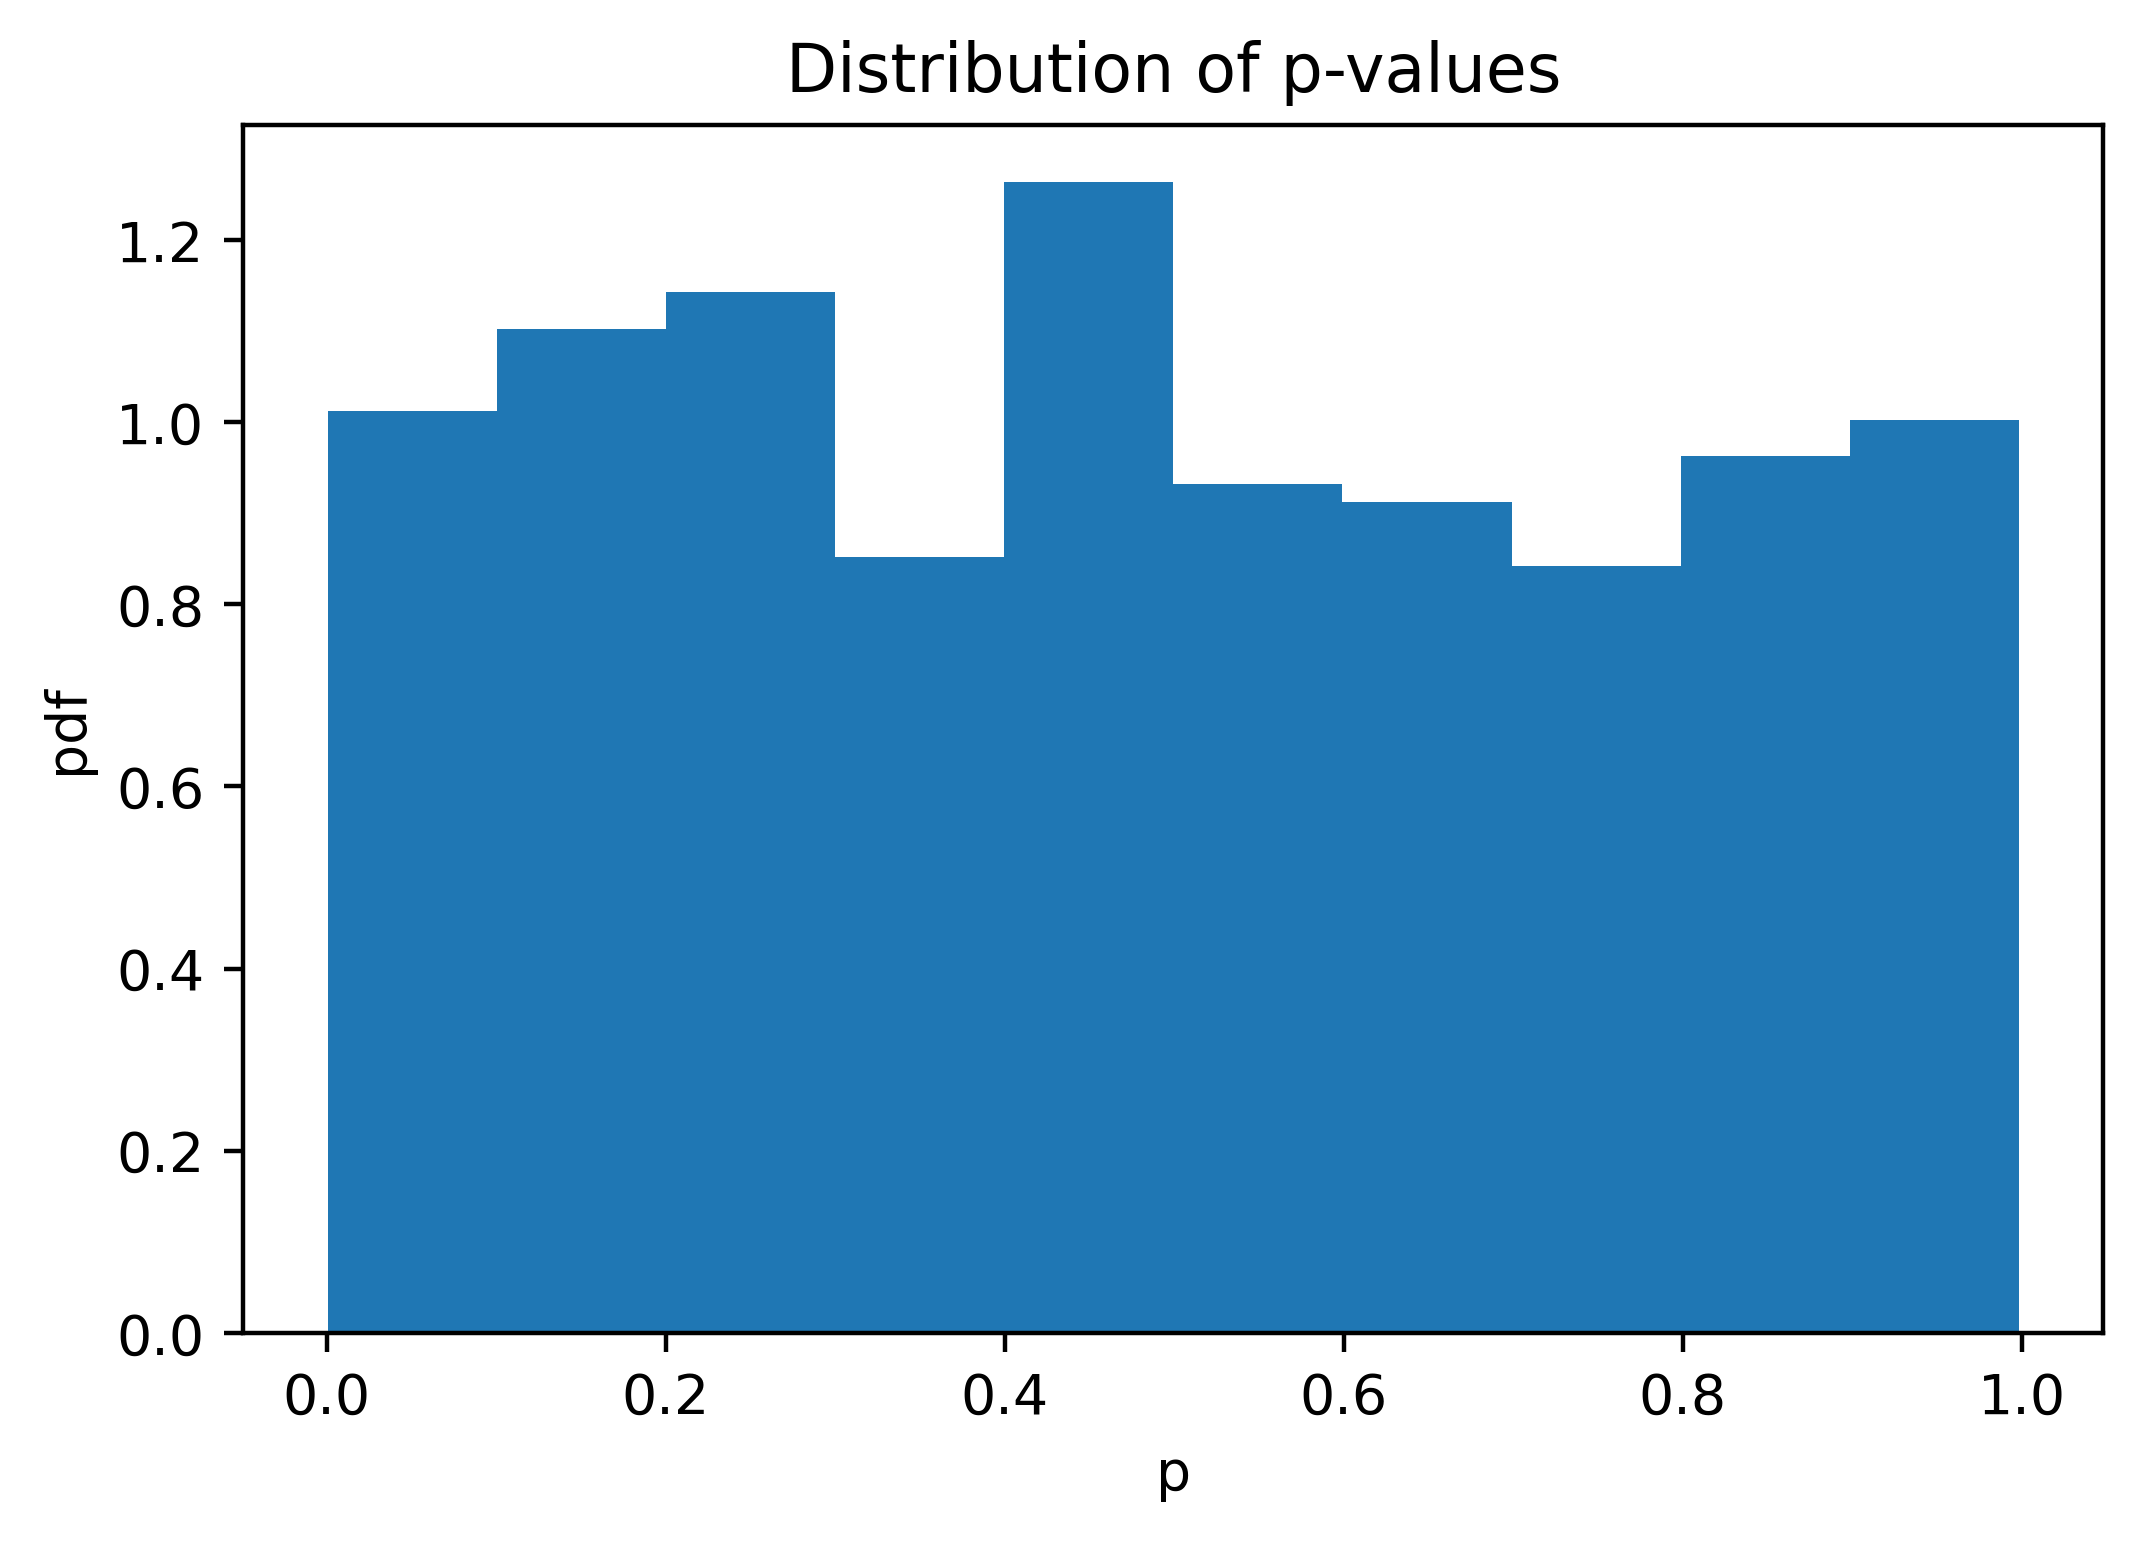

#### Turnover histograms:

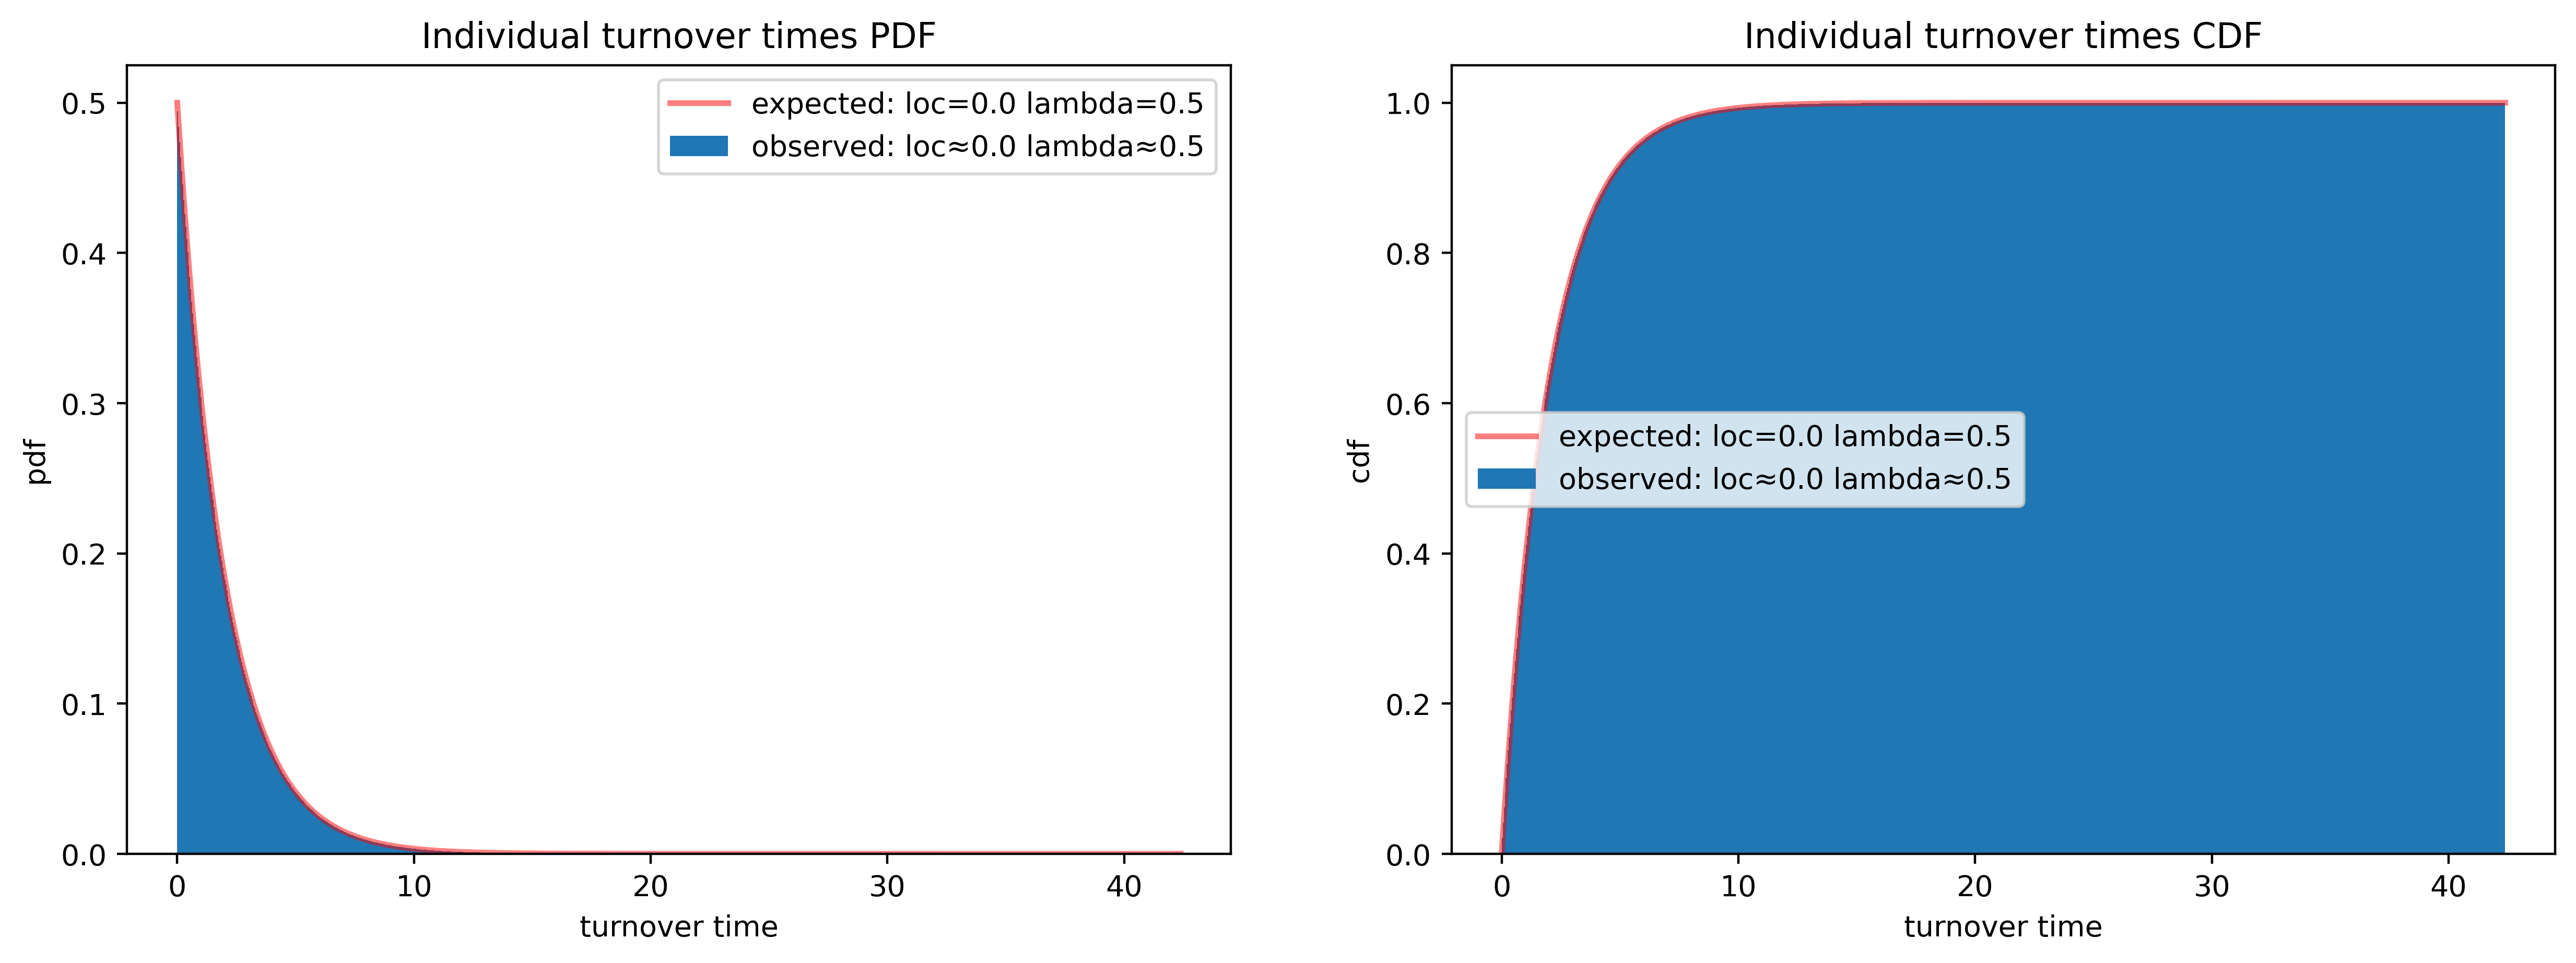

#### Parameters:
* seeds: [15134461280770547135   554652714912959444  9538361249923102775
 10495618800436946968  1129222570948787601 18339967721577101515
 16877816808618161955 10782346125393558166 12901417492850654088
  2259992204456705458 14543484611749901548 14207914045303194995
 16008282279420737138  3178308327397060698 16312002836417630855
  7392277958887571724 13084105240488473466  5103411775537870316
 10525381762489334495  2928890600891656205 14370506589414693696
  3031923027416872600  2780709010111913085 13291502593231053295
 10635735933082963681 11282454341456567440  3565747462604429552
   525136424903693705  7903787472507071958 15054670084457816780
  3041676059151690979  9034817520944944351  8301469253911161290
 17944404613533634657  7902859451583170288  6897843525016770747
 16636555748437442435  6962166873194104581 10053740503627566070
  5721718386953215343 15198636997829466786 11820206276776643510
  7677379484460037239 14232292747615479758  2801542372048231633
  4993572632129696551 11762863950360945606 17497448517742630858
 15261212429851752571  6066257670234117206 16483710008397789702
  1976690257177599346  3301439489769339143  2519403834975207902
 11456442624984325091 17762882407411713665  6387235530890607632
  4710683497484647255  2139551724915533641 17192706046445277392
  5257874837900914134 10737879818394469645 16790501414766957661
  3702835734624880492   801602833283750063  7941136308774874713
  8787468047886872275 12650098850213088780 14524671995456640466
  2609163680365808805  2958030282286889325    45780457986586296
 15706575716790970649 10845258323356081228  2795865549091024117
 16952400981974113895  4904715708804889427  4100880973104228392
  7814299833004620500 10946113661934489992 13752607163114373574
  9630651617488681689  2742843570092199078  1703670527043759206
  6241169944184014357 15654675246058910653  2121941773816435273
 15666872073971715857  2892809514320952967  4297632060356052064
 15422730378680878310 14382181821232712185 15568001356754030625
 15012751796353528444 12115608471865556102 17682638059306165155
 17004539490702356509 12074060694816182967  2644886083277800154
  9534715536142017645  8779264627408671483 16811449760987587453
 14478538275555932348  3166144339925997631  4495467711894553730
 11091701096224360205  2358415583711368121  1343848146126760421
 11490699753451912220 17340694847971309703  6662221141315159771
  1109422129092450461  6494380022648760795 16776938137236212380
    30098811143334699  8121066029490865890  4912541501392860737
  2434538459973263387 15043996587941870143 16838803236710891498
 16320045975378178191 15637614099568004682  8110860746615622465
  4656579215641043167  4496046599882443636  2942757237118642012
 15426658608431300912 15884964825432666895  9231454654051271382
  2791970494950418409  9421584160122333873  3363882142245818100
 14136200907672843362 17419390149630454840  4113489860543862019
  7008655613372842624  5596801537608749188 14466188623239341071
  8571252238479571457 12523388152191526606 12359535992947706506
  3057144869002714277 11897329212650355756 15453601663190633722
  1433558496355769880 12866006120332187082 14466060225131280675
  8255185119241614162 10732333771696906921 13616932178949458820
  4547392112894986964  3027385777238534103  3469024566013357461
  7470281473305563267 14720540994107998468  4614860552045899908
  8130445948761526811 16327813558052040927 14495431194252197636
 17633777334796097674  4015486766840567388  6001408806231530826
 12272840748417526357 14630642112789078468 17776406783691251765
  5527549638582329124 13737477267266083212 14076049410742224152
 17355707261496190524 13263948397399864347 18379951083433917665
 11080625550851877331 13911348632543397982 18248067984577276899
 15464710130694648194 10585519231243184403  5362119856662181589
  6185404280676011070  8269806522481642791  9289777668005178728
 16926459888485646971  1686944306998083734 14571577279254261377
  3964534949960495409 10320954273540636917 14950246876135514409
  9292750402399481227  3831495472183025420  6611187240214771302
 13581784702578860479 13048226201759329647 17598130092214098536
 10732375436845548968 17367218550035975028 11907831664096735865
  8412054850469668630  7526555614450219739  2311389337457600128
  1817534475893856175 11397875616449010182 17907256171892190644
  3954818190127833770  6214344407082532939  7710397527738354430
 18342664818635534843 14320700456180425353 11839209623035216993
  7946537021511033275 17383202877925679597  7456391382047400832
 16842225078455837881  5426265914405334625 15585087083922486399
  7789839088057466184  8019392132155084588  3657064925965996379
  6492794933272819626 17778251832148073171  3802696329703548658
  9243019974105528264 11234187912622036199  2121467764975222720
 14064092604737911502  5831077950152942801 16081841387867611127
 11254532747696860243  1119324813919289685  5994704877136557489
  4413126580208939277 10026856281763395512  4445255705871642865
 12857866593360950753 17684304517254844396  3520713397238166328
   614021609489388269  8929382358034159009  2040065323393535028
  9241762241552296964  4501445852565779922  4102610405598176952
  4095033511117532382  6803009221879601733  7130004528408722008
 15541057191548833905  5898389912307011648  4971075846135814344
   861531531344169763 17274405383499062535 13969916963326041323
  7637228522364350198 15158281017663644133 10821278780822186038
  4683569796066184165 10045492112011255339   954975640053345075
 16478353288672132736 12788518544758358362 17889036200174515296
  3807307166928505781   222974032022632811 14319571552881757634
  7392170401155792201  6324136384255285871  1433174858044082051
   557869397980389462 16342679866723910768  5029626259301984551
  2145356534193431330 10367722041871186024 15803648663682316528
  9868604746560179666    52751608797057082 17986828753827452056
  1936553599219936096 18152762021846208414 16717820990862365510
 17562290365018761729  1988559010810345137 10408859184434182548
   806835188457434811  4844524833208138887 14999582015303219812
 16407821035371142652  2730131569183341877 10747046277208461758
  1715255152438362215   852676343770740947 16829387859278794061
  7567627830409807012  4238737972294083873   682024751391288152
  6374440291928064297 12540605607012437680  1665798723935421525
 10728421301375455724 17757812329829830432 15433526131307473625
 15853447072728849868 17469103181974913001  2906641539982355326
 12905085676032001392 16222541824928934200 14654887629330075739
 15876685649807655533   527379053820432877  2418196650733484093
  2004369666952648020 11821892438736780185  1866892683935967032
 12398219441362596368 16686638452355980352 14959432723688911974
 17635546192069793615 14495519321083021953 15587268340114531747
  8326084814596339048 16703168830164993352 11038782806273084872
  8340125830422365484  6862485218285908064   870302735506807143
 13001758947654834881  6884402757586215328  4540348382620671360
  2754481469258497568  7120691156718938365  6309270450319178597
  1729607688462723667  8450030596449571152 16530741700246313689
 13001134853135676433 15833679209158875755  5247454169235436039
  9198247428528404523 16747882410153918907 10537225578530074149
 16661709310621963276  1747664646033241222  5677011999456056355
 11736607751866928335 10655189486269883640 16612894110731302859
  5461239595203286081  7464322650495326733 12582673956804172734
  1238667217180322999  5531349636509352343  6379570465022145656
 14046768616753874702  7095747887029194467 15642986958945766705
  3370385201053968654 16049737151909717143 15420539120201567670
 12199284381195232022  4328582411879164293  7617832275673133635
  1767059595038859568  7083646624582050674  8484228547742675878
  4269659017444603553 14377623261966599382 18324646229121820154
 17373883509531128400 12404917898353668483  6283986766333067655
 12163007689115970215 14832763831351517844 14151034801105844954
 11596144687567937967 15110048620722058657  4227768173778973444
 11158774313124444433  4868006091600122091  5597139708197500795
  1749019921404240777 14245619466014295999  7306057400986296274
 12068745021559142976  1711654654272540088  8415942230616412059
 12204081866982177122  2248472883902953969  3105174634272933266
  8553449521645015806  1380936212463407014 14450346689363950765
 13180013768599121775  9424079262233500328  1599548814948334197
  3921692582196456207  3006481091016864403 10388557426012736044
 18315819699496662736   341449185883621916 11291435981694484016
 14982119326582245094  6736726449929593189 18312304568312043260
 15014579136715612897 14136011503401737549 12518381493853627413
 14070462981469224921  3720458907923602711 15948691807299342705
 11713721340013447061  2612552344768832876  8145150554927652977
  5935220653169576684 15263091717997302409 17010487286186059494
 12963964816588449447 15364080122960131572  9379961831965767088
 17480198690538081297  2195155266858215745  1575196249354670783
  9112328553032846024 11664917628875903434 10549081417598647521
  2812296137513083071  9422775487410034115  2668393501245369633
 10203298104591815832 16623291767613189837 15237464611538092671
   495023207249718902 10504294105589738722  6831742256882659678
  5153498035626867891  5890638638583105883  7802182444630369203
  9843043124959300744  4003948689625303894  7239782104516210306
   558443459009731119 13952992089774220588  4329645176558257253
  1642871517316627751 16269143684650619958  3734587898623244037
  4388469371076823699  1161816406460546005 16838115273997508565
  4539078898291576967   791023077316424429  4633039204182012592
 15605844516740636096 13280071958641444706   864859637095173072
 11699144144640677971  4202100994527465695 10382369887764559193
  3338910585462313311 10303095795992916509 16553856596412671275
 11778013912194683358  9429922104239857559  2974034380052104625
 10364057283568104895  6935454572677600251 14962807638204545170
 13284881324222771917  3331149709464716394  6142887897845348868
 10224282645843316463  9654523507963933131 12731166946021523120
  1752115139443055585  8255727873875099543 11440254939926627369
 11305163818326279348  8355401016048564551 14992086476523521357
 10278023990805396905  4032433220174856512  5278780649244229957
  7299401780226409389  4133464082285390327  3135055666140553882
 17047785119603103175  7466014651104838771    49007615511686350
  4228458326008247630 16832886691583023450  1449711839807074783
 16279955508301481546 12042570524077878354  2957754078422222608
   443092177726475266 14225518595219903809  1328522711264052756
  7427460530928605809  4695516864881419599 15691198366348749356
   277442610838849780 15172735212425207561 14000868030907649600
 18344667657439316406  4238133802846235568  1384370592044682756
  1170755934637646477  4714517286166887927 15870692892582385868
  1403967952580955999 10608606568276437450 12344664543221591368
  9550555625912989611  8638040064167113441  2556778790726873391
  3353326105813985186 18280363332543780402 14704481288628874608
 15944174716855720640  2472429427012940262  3673831319322691151
 10722782591919847747 12418379022003287547 11995395102981845145
  9001098979610885491 17970800854761738758 12966835853100917393
 15606311002925332156  1597243734219832802 18381313891011934462
 11832795941757268932 15538517764477855337  3801298086111589878
 10110546297370489280  7968584000527093318  7905926636666238268
  4513023280374334019 10687610650879029402 17921280578422626222
  1829961562077633300   882325061527861080 18047775469622876794
  7901070602379238892  1447823467302762957 16753167740734262027
  3104126482585762503 12202194083465539763  6755043339745861944
 16067128151169015565 17071087337303256036 10397444338782407903
 18130930090363943514 18354517216114813488  2074486787705980360
 12491420083500167697  6700208584710769370  9712960599467749013
 16811445810169537940 10996534206584396185  8598274184255403530
 12593008211850162174  2330085912155424964  2249537150062401651
  9561740867150907812 16283493999739262506 18128153528084618114
 10210682096146762495  2904726871296701205  3736002630032729897
 15123067956935994650 17844271518488332768 13329360625704798841
 16900273220476911067  3883814013981111595  5854612582507470695
  3426723833921839469 10789277956487578407 10148696006252342329
  2680762352020239449  6990614709594316823   246822756691565024
  7021507537362013305 16883099534165218601  5858987537001629005
  1913984327067351859 13613203604291729423  6687404794396784104
  7665367851733998661  6656101515012817184 12039622478246279176
  1281692752037312917  4651964706701886555 14553338256003382285
  4928713355864783579 15243584651907568790  3086392366856038803
 13666430477430297585 14236632794645286830 18127024213095606294
  1260257210840073577  5932481960965328655 13249486124119591281
 16166102925938463972 13589793892477556088  3798911344624492610
  7781694921504010619   212152926575929304 10060866030228672201
  5469601612354022892 12766349961979155374 18353702086119303972
 17270675156569194546  1601909173448051031 14174845899878807399
 16971856640247920184 17816033211641473485  3668085211736522256
  8860086045428118983  3173759486786468056 17797970285200465340
 11238240686931040194  3247340009556551702 16337664826030681209
  8577630992752783599 14648532912653001420  2469331559135142239
 13210682543855119739 17438318812445897719  2990755221488311931
 16268674700973884520 10314863909439064143 12868233728974899656
  9497537507622261995 13515048629924398467 11636679204760387114
 10309901262276667448 15023071016412175398  2612597732943852692
  9442986201367655024 12874422674769271693  7732047969801577461
 17083376800818696739 13295130408269273201 17126242859563725614
 11596183157907704142  6699813442112302981  6777813046023439161
 12252254663516799608  9918997784542091677  2973083908883927405
  1795168677237352978   991389248036717739  9068666882156150492
 16638596924757748331  9780621727503062295 13847026785750249497
   121337865064026559 11815030022092638862 13670046784999446249
  7310984644864617173 16385838194624825562  8114408464917071789
  1343885433810130946 13047452719152552949  5693477111859544374
   790031794042989568  2556715012235541707  5184020240397543629
  4158115062679630184  6669513984355039592 18197959579079150948
 17976120225685247165 17992321894723674470  1810899325709894863
  8548137866448948783 17350782040689497208 14815609721184866831
 12662110010302005603 12458033435559030709  4623239974155400120
  2722052022900616039 17965569934595664284  9609412409597323415
  4743516840347070668  4619122517045347366  5090350381647395841
 17911225407680692839 16866813310617120495 15095804895152947665
 16964537794885655381  9764067201173445245 14711039151154740178
 18141468736691959954 13096927222454651350  6831403677495121239
 15391439210594106628  5740591165905018266 10331202361819840193
  7371049612717344957  7260072469371495820 14636155165836890362
  8610296493123444722  1256052750312416582 14651294229620884904
 16347985622579434277  4942750479759489529  4536310911634875404
   658051234854112254 17312926943028659040  9475702370337019167
 14299567274066528852  4363378104997419541 15759757973870102291
  8598819777337470113  6494038566645353868  6776406756731581212
  5758646965012129330 18092017434490995071  4185270742848915016
 14728362992337494841 16361888875234412916 13560425139959682901
  3681074076044196303 16960594560428111559   487507699540071717
  7665465475227709096 14171814166028211307  6246698667454564717
 11491840604161933907 17398984031452467700  4012123501107779611
 16524792026717243482 14734079824213534628  5630822751553556744
  3144609560595207486   892593068874160488  1126431010569114128
 12292140546957894983 15789252346332514792 10709680087003064400
  4067600267555072467  5583667149048632617 11097291672042732261
  3599978547483641395  2561152113641819839 17331337977281145689
 13882263825564958993  5045035998125319123 11109369407754885424
 16040093460479524576 17104260436365523578  6550487808561255373
 17348669131935737964  3966800135936675594  4328833177906464726
 13489341780100537825  6706597730827363025  5102074208186031999
  5865814940641862223  7758114133456917888  7303071117022838679
 10082336802287790707  7695711866960838329 17291893375487560259
 18213535061152799350  3749124417182502487  4332254070579414881
  5042678204586512565 15038835423835084436 14770692023630304689
   471774800919417001  4067538332572435507  8977653811841689999
  4146485916099805133  5194149999837509781 14541256942390278618
   126016281042003863  7919592040044609068 17215680505174168954
  9903026941267592904    83762140697107501  7184362313540946983
  4394485447501940990 14342514050597836644 17567223610072118324
  7103015303549396542  2790538548816880638 15387668826374311729
 10433202218058928494  7610222923789330822 16139866969590255548
 12977974285448599663 14648645762439159625  4839806124042600887
 13364440481183986167 13757538481460429132  9094033368197685481
 12213866187367628390 10554186865016156354 17595644348728883027
   183689339539990354  1423516503461203005  6442553080035038718
   204096662121178191   153626938047575692  5870243347424041771
   195105224829447201 17547268853206419203 14370835278850150030
 10853045544656515981 16654393469343911743 11684051463785032617
 10518740292661800792  8310831219156501819  2734772707068880211
  7855231005510341128 12022397857921384810 10371670409866703101
  6433321596498722402  4862464195130299319 14334462837950348810
 15319669586185093861 14300235648906349936 11382237681079185869
  4321115689264293881  9239155142427722370 14811547889077974241
  6388348688036530598 10032608015452093338 14767530610219728956
   692273899327418205  1569184886475001941 12048545037270770453
  4021833301112936557  9525942109415465175   426385629531855432
 13194636109784632925  3574412723806713572   692885329456274359
  5889493702686649848 16209638888578850842   707364290290270980
  5029690726600492015 15046877475976657037 17403434950494545285
  2143635966444872159 16403219767661851634 14161678184846509987
  1193164321372817622 12412671062781668830 17912091155318501149
  6166039799045697770  3364287847020614405  1931672861526444939
  5777160775843003738  8598595793663784261  2146364678696185846
  8954439975848012958  2133426618292076092 12584195753473167562
  7988941028688738890 17127984525913240974 17728329270322914124
  1604757091345751158 16603879463052740075  8604901422509635582
  7339195898901340346  8671079078277292251 10143969740241759852
 15264983437275546441 15897513855701274751  4374860865726883665
 15243465681914974191  2690709025504239556 13085131687213674611
  4041690887450819632  7495133876426982132 13533801654175039979
  6986099339251684982  6270994243713489381 12692474972294953804
 12441852874113803022 16539944878398474227  9745651631275826908
  2905283939667107067  7106010300972573681  8815092606866005037
 13026077603441017020  3473106772376250700 14308925952368949476
 14103837674545904211  8757383260309994234 13837191418212278054
  3195211025246160766  1159042907861634846 11783958098538950897
  1102741280521737081 17276883170485182367 15653340688813309984
   380450141537072096 16093098161157839547  1183759833578762358
 15613611866524827193  9313206297588966228  6710953645670697562
  6369530264987107649  6619354707591670596 17092530141920309726
 13901149774164433338  3763549966724543522  4160988182322897614
 15795605641811007930  1471365043728268761 12010571464827190973
  6316673717456985564  9278366213083590347 10397547073330994594
 11037054141429884589  5105376450903674051 15004316418322832705
 15655407119974754142 10437639971362810302 15693269270583559517
 14145344431324655498 17439484290087487372  3061746887596994399
 11885840053718909485 11537337817279486031  4295980534902772339
 10483483096632818566 18390291792040696364 13487568990756363142
  7160244874148322822 17852083594553530069 12352844632670698271
 17216539234618061701  2535089404874720711  5625056685457636143
 17720620394364495809  9278639793016882153 10668615796150801349
 10149730553050148129  2430880233034374119 10389277823278096503
 10781588326946429465  3377186708350310424  5802634414564370598
 13182051562281306495  7244111263562333284  2688002876735702139
  9910573896756634843 10608625707209539584  8253487863972030214
  2886214546394130630   830749620957368861 13625221065945822554
  4565203061923655241  7222328582415821828  2248680140963168863
  7206789775894572317 10402366378962790182 12045054887455433754
  5010089024009571536 15622832509269379249 14748710965725305884
 11772557203407396732  5619429710203798277  4344985462326305213
 15126040553013139785 10050840466937764019 17453930014703113620
  8660066590013839541 12979199063534371629 11794117229083856642
  5286106477735324799  1247961554849438144 11146484824998468829
 17937358746091628825 15516579391132607290  1500595000119524537
  9042016213061382808  5989973985154471118 18079257917620423104
  1375090361868604086  5030832930526138803  2061237783639014319
 16376132136437324921  7887123167277148472 12694750775309597934
  1813623301999502888 12903980565066741545 13190310232930788584
 16508546989808501548  4975071632125117500 17746504287730411428
  4361284416245665695  2195435983902372842   195682572594262556
 16225646176724935112 15574772888674554442  5139872767136087525
 10646754765096057086 17133008320396919534 11930174857934874252
  2332345107684428811]

#### Configuration:
```rust
(speciation:0.001,seed:2332345107684428811,sample:0.1,algorithm:Classical(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

## <span style='color:green'>Gillespie</span>

#### Fisher’s combined KS test:


* p-value: 0.11262665042218076
* statistic: 2076.998375292736

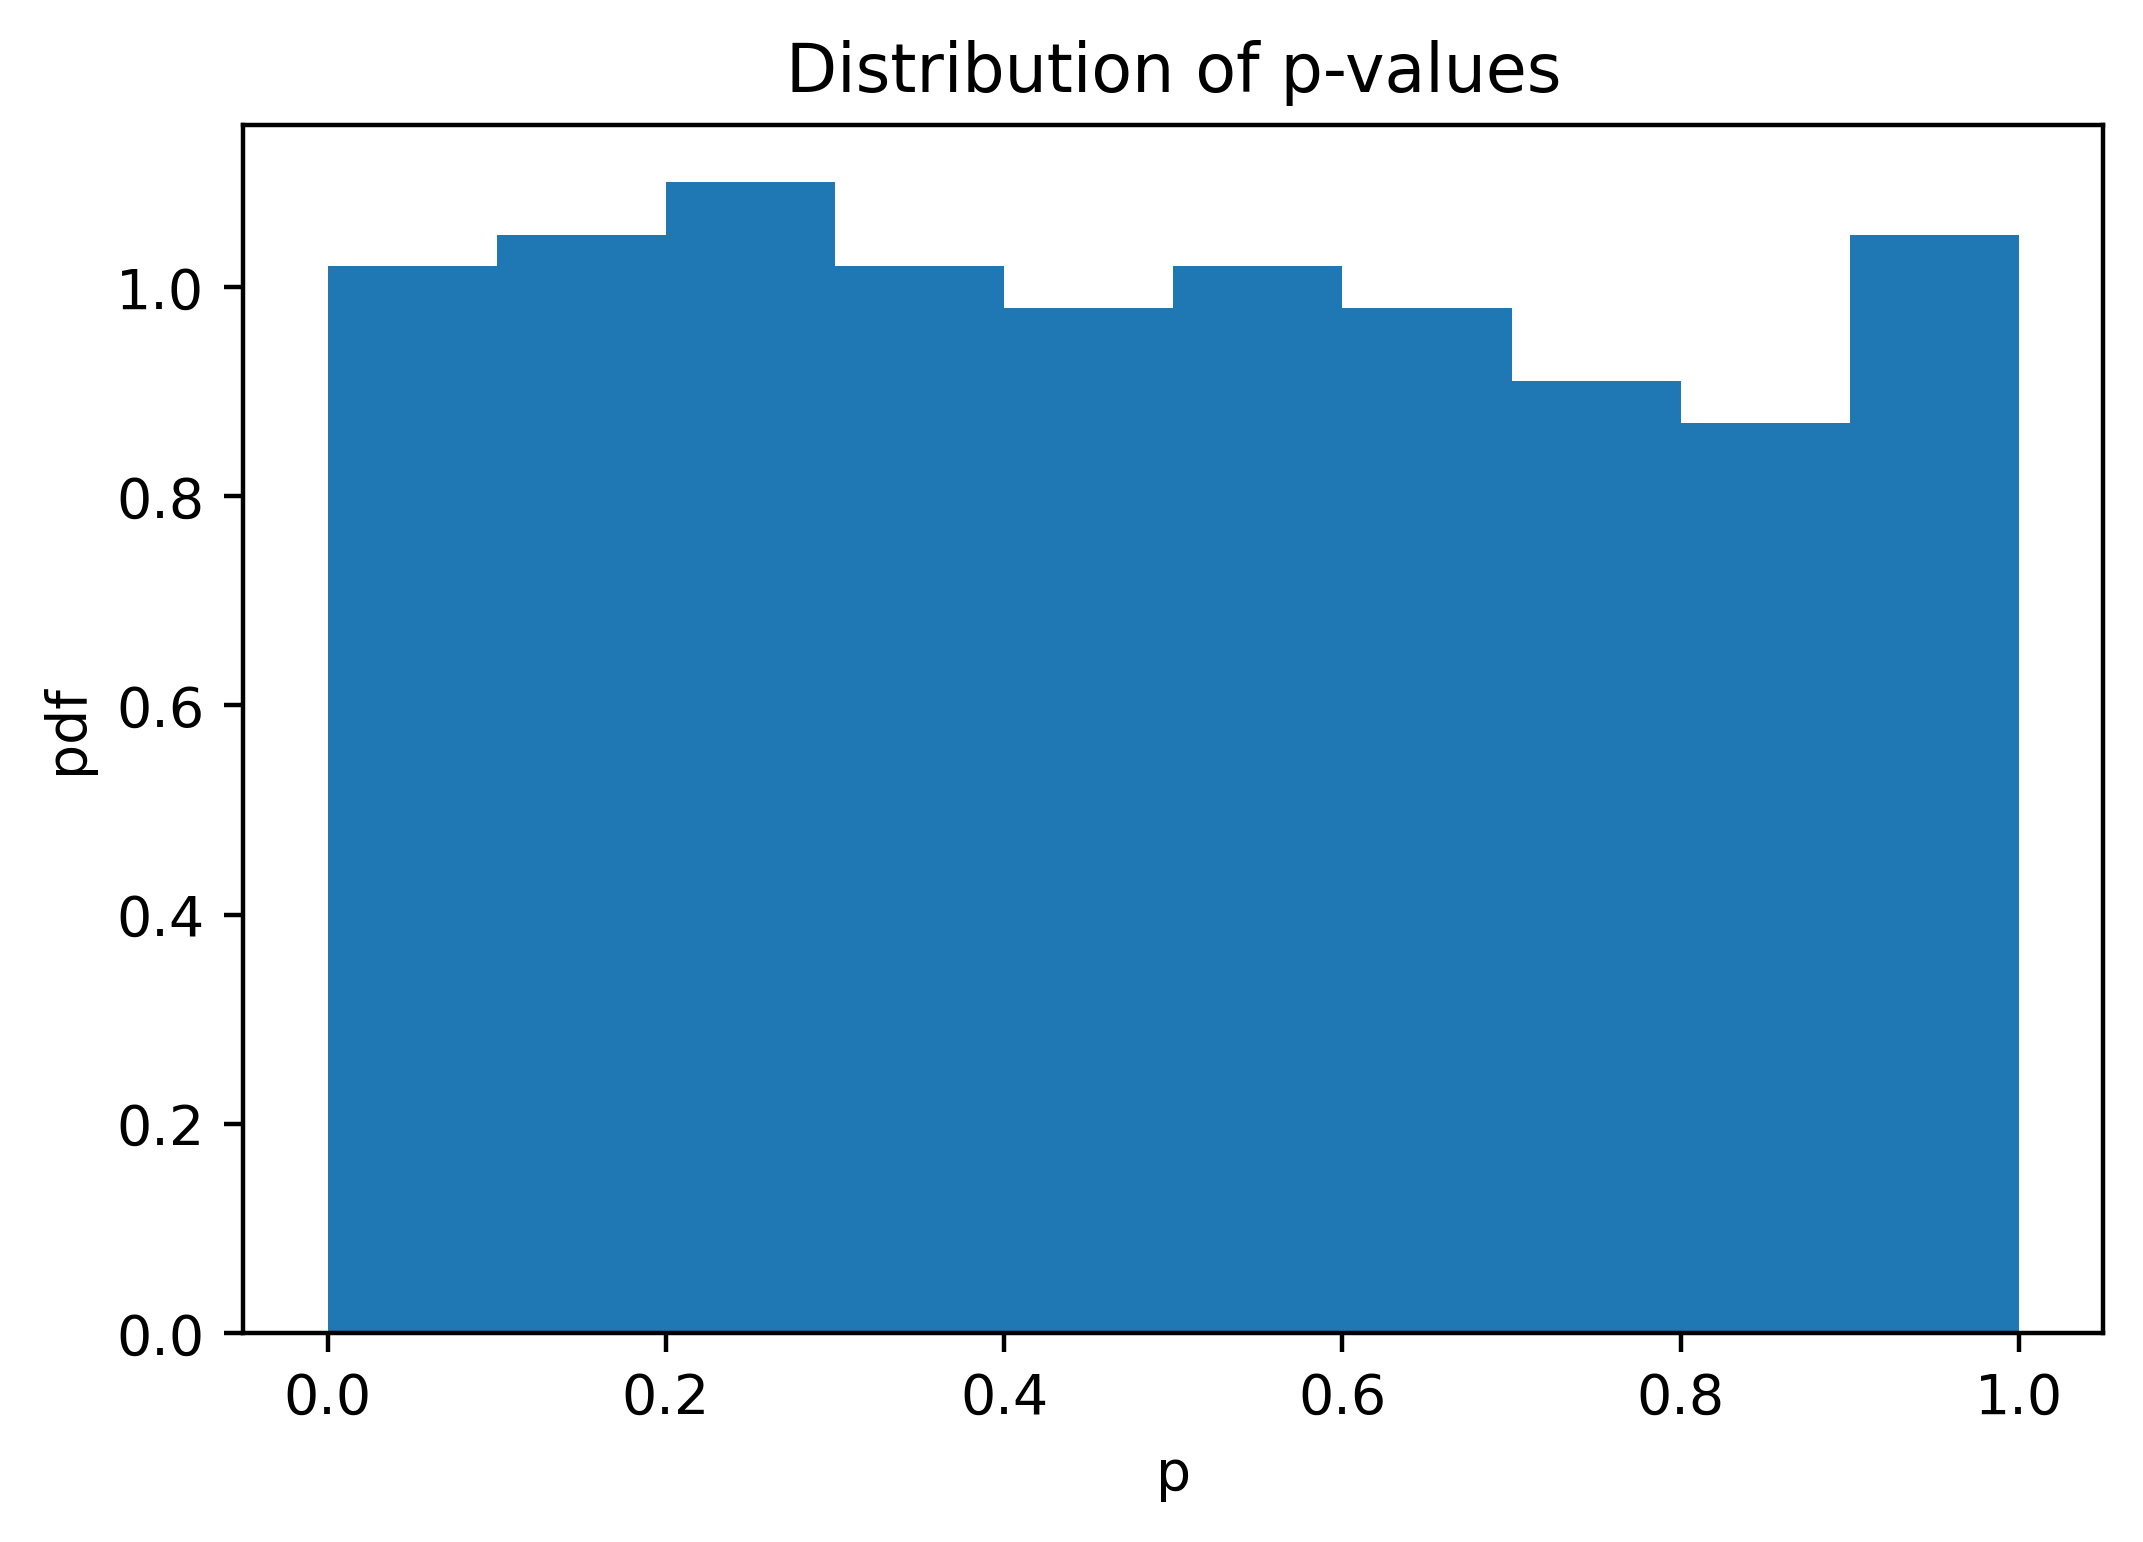

#### Turnover histograms:

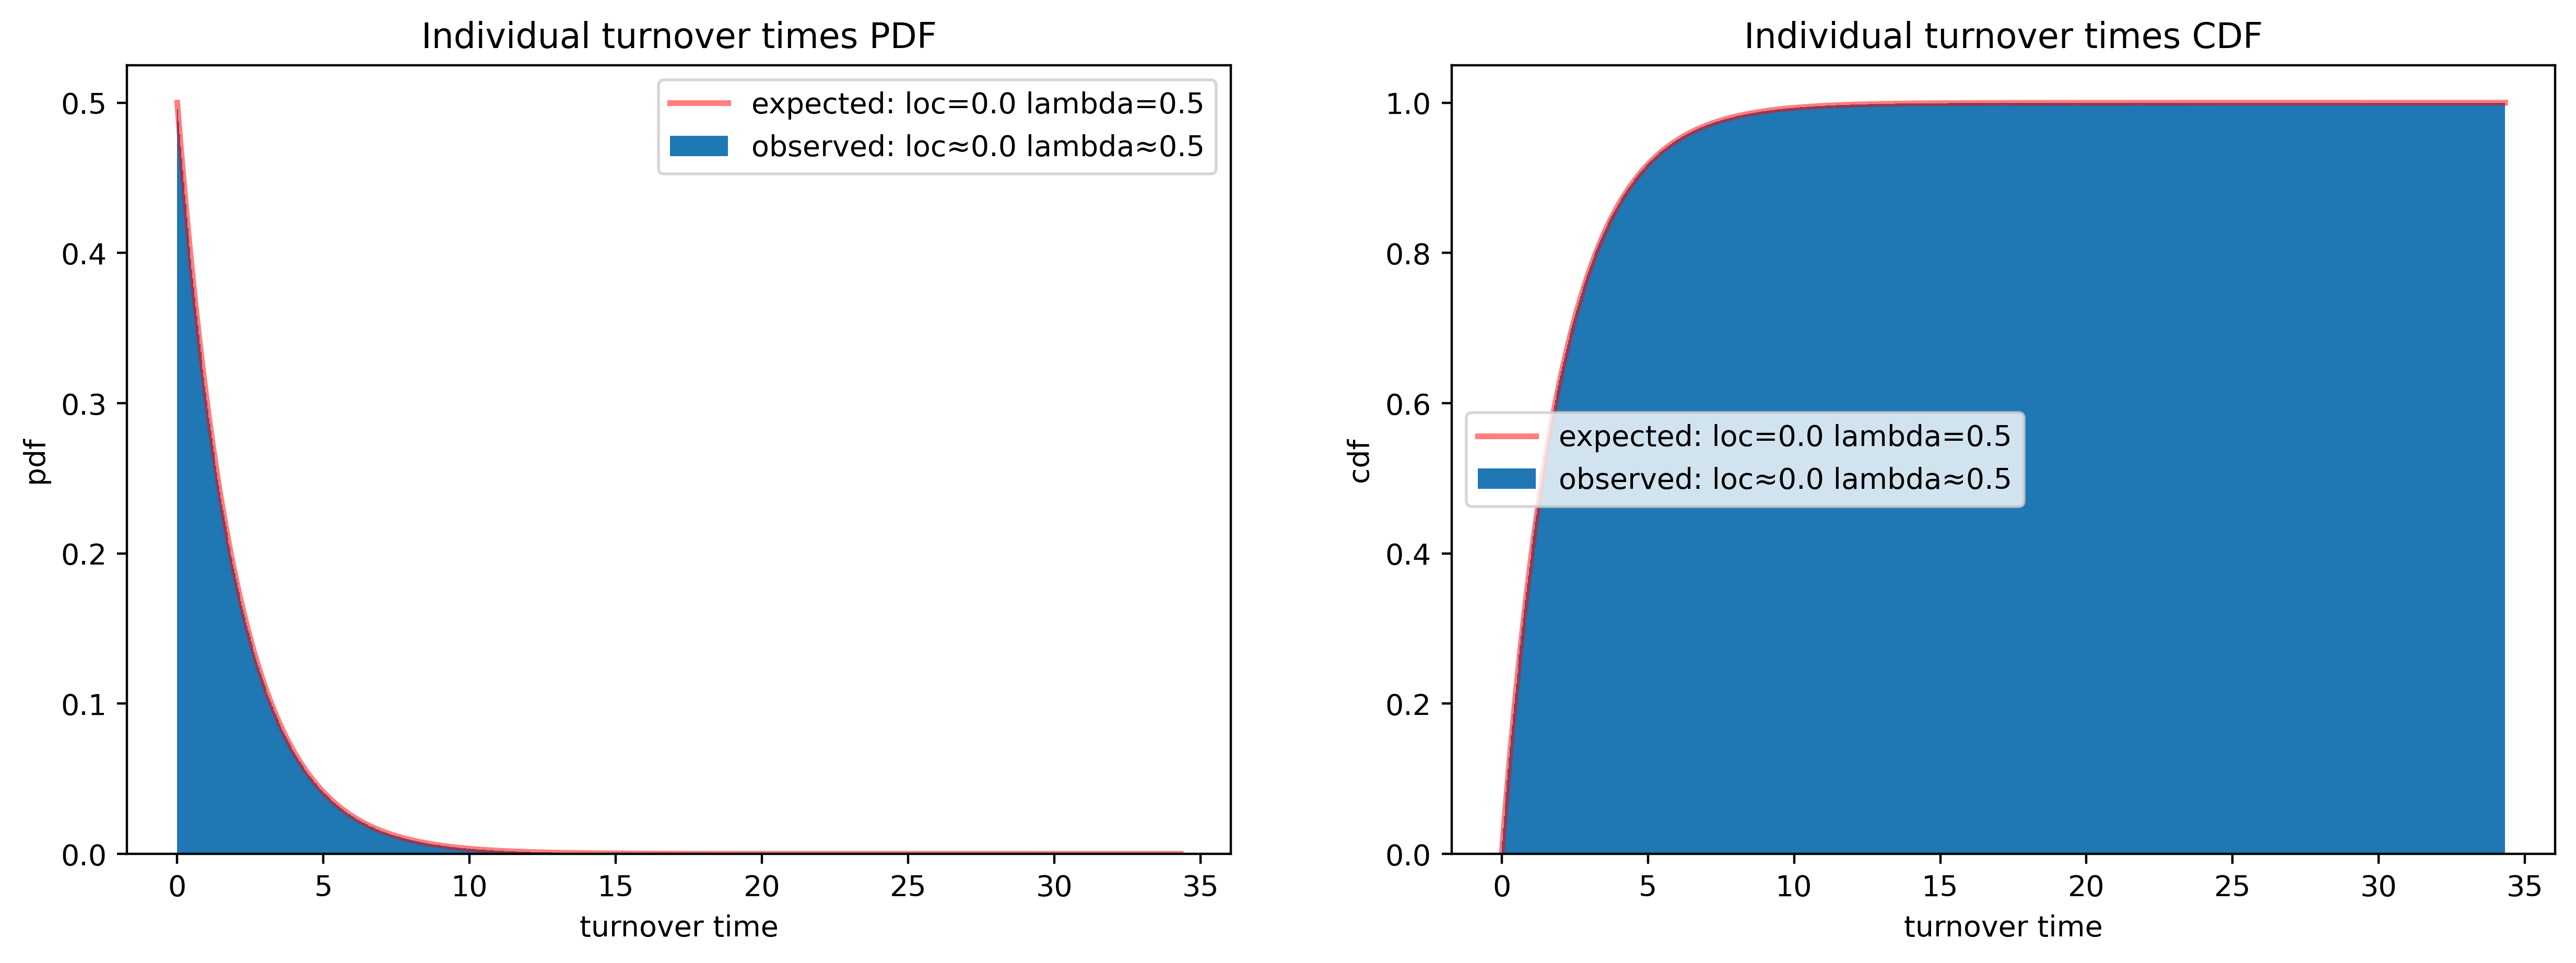

#### Parameters:
* seeds: [13063661436068738463 16056293771298100750  6047013158644283124
 15713209622084507644 15049226274678524516   398759741869366227
 11560806103985009347 16911135787586391695 16872466319614755530
 13892339590307470481 13737760584060327362  4893368783028436258
  2603577155725192468 17709250665162545578 13410637757028305496
  1550300944497942683  2090797527028752398 13297826811432870971
  8080561920909828588  6487994798118944596 16165710855067241287
 10487904629887924883  4021695006039437343 12579379088663884041
 16804892447893505140 15073726708432758612 13461129034829842041
  8001364175799931308 14007561586195937070 18311667309089844147
 10385005226176905345  4099159800407535854  3768150849229577773
 15362843244357758212  4821723060680187087  9273020374037865348
  3161894206916223996 14978855430797630699 13628808306415464463
 16836011832169591514  4150134929984789529 16276528471049666715
 14599504051837519612  2606407643755888437 17455145441546760879
  4128788445907267575  4428912721394941423 13697552514333402491
  5639368896038813324  2575089068665294767  7207634478616838392
 15034023880500933959  8134927801492264429 12607085313047127056
   653034656711698038 10035554579664778205  5938766354711003427
 11306375698663285145 10981939270488695236  6604986838229726046
 12676116493934498283  3943758169066375244  3949513433467509050
  9642776871557441946  8075360179113838545   403418764453634176
   706940933968989092 12565748645305717442 11704136863360396041
 11847432939400121503  2567949362072469292 13926580564470453621
  5838936288759374333  1309775560042010805 16008627060391734699
  8536657515108438673 17969781240443884864   909795348183744525
  7934258634426543623   691431111037094505  2722728649779986829
 14939002903426002478 10272746412909954414   668445150988358611
  6680655369195344554 13352557545501693833  5952078227427201299
 17968903335278185518  3950983612702357219 11639561371548939165
 16666500502859860506  2377555842122831428 17051404172829294026
  9195187108069510605 10477387389749119153 11074557955002039741
   401635081413382119 10958726730123682442  8458284629431963614
 13733749789699964138  2694596836433885673  5386387778724768929
  6579448007717755412  9515869665590724502 17383010365418849748
  3701722215573679706 12332091846623059137 15771506258857746635
 18203050076142613639    80094650620734566  7799264422563257801
  5875081571760825283 15973562345732051235  7902900904137823294
  7773150433566479825  6883920227331691702  8291550455265378196
  7761215205212795989 11849923112605101547 11180622980287749253
 11721768331909566249  1170157959058499413  9936508562685666522
  6700373007062118948 16172960391583040556 12074548638069610533
  1739183180975083165  2279724780121507826 15715951910756674982
 12487221380342254697  4348193252215493688  5868129727802257456
  3869332313851419191 16652203910532545555  4523652424388280608
 15388713529778162982   164808946870503046  8563242283592748722
  5796734386517916645  2780115100752673289 15713659955520026413
  3865700325658093792  5508060443924853246  2760512635683486536
 14662658494767734158  6954910366508357740 16816254799651028014
 12101758387060192590 18031920546766969468  1065192561713110100
  3853698987389522801   378183599518036226  4790596849691656912
 15587711874249863837 17121746697721171232 11261986980582202449
  6972979434572170257  2163296706446863193  2167090638468765902
  8712316827890628274   910272543917183369 16021689028353472961
 12551049870435220676  9591277894428390993 14096943571948688959
   828373488646346417 10637018023293136083  8667537280579368499
 17618479361892642543 13909026699165190361 14682059735420193661
 13671695558262881387  2550028381227741243 11653508446181489069
 14437266636725405165 16850813285449783398 12485496258622268273
 13857648652753851481 14628171008374180477 10748541510595584249
  2970911422003001250 10692560136223128987  6963192260936355550
 11561145386998437714  9514127465862973114  1624365831099396685
 15413294020587019929  9768155067348417796 12494094275715535022
 18058954725207387799 15343922290025051010  8419751140282341215
  7007394082392861189 14915784306615667304 11286690240014487310
  2194559055255409205 17804432581902285895 10102898889779777635
 10947799474057626099  8585113792542016759  2266554431089131532
 12879596138174840782  4598400302392342986 10924096830284858705
  3343791772627495104 17847079758668157030  6425673891426851462
 13550378950852060669  7583574100019334010 15643358691131660838
 10191829955340293868  2771153441892098908  5641973923810542740
  6267772584241285713  1950314664315387065  2576406462982462562
  3933632363443812518 16642874501011465386  4980994035440940813
 15433048856846557189 16925907518481893326 11719571204394471598
  8106748820519839243 13915005996824737514 12143919449200448063
  9017756445221550784  5453367313118116456  8856978903014689395
   537352277993721862 10597409622690928803  2125204825773454396
 12108728356668275808  4490061181710275368  1881178476866577721
  8756949362547794856 12945129728921313724  5714405855016274037
  8970867291628982105  7511758072897489089 15773373702216510626
 10054337008128300642  7892047741882066028   601794418109748967
 13321301545777698555  1217898592808771545  8570836060801403222
  4749240699927542705 11658654776554945994    45762918041212615
  9208783397950394308 16484646503917648953  1242650403416834478
  9667280218347460120 12758774875843311832 10435769119713783367
  6857948881136978861 16982094155009091749 17377890753970089819
  7278331233357547679 13003743603079600996  7554454664814811538
  2583968481779351073 10367083566445442730  8409743747607537176
 11131835073539052132  4053182834660039685 17919772482995379127
  3423258727010083970   737198398524493675 10268025630681864666
 15284207763243610516  1424719213543321748 13521912724647333217
  5312347663986077975  3766285540317862312  4260355809307806209
  1017643425033443595  5649997461628659464  1742748608527976954
 14075202790556127080  9204705472150445071 17869521506406652723
  3038127146830585120  5699325056640937237  4214158878909736873
  9752114790058610574  5412229565911238035  8114388354745928569
 10416588005224827176 15873321113303538097  8299225296647150206
 10160753144397911463 15044156104395576153  1625693276831760021
  2772268387281416170 15382712726213471851 16363054572897642180
  1649691791309765181   919196377871122603  4778791025971996154
  1254832925278625294  9180233396425659085 14584327613072912439
  9373197411797552503   663206479928479997  2349625459563802654
 13839070953728097479 15110980582938150160  6471926035841197487
  8268920209774700077 11629604596773939258  8102010496447113894
 18349922312104424416 18133863586949168182  7092208470551704117
  5396738573714937066  9247728359139350514  3924397483629474376
 15820062684382658558  2586921475210158049  8770356017253500713
  1125585093650424758 14047586532299754693  1850199355586412296
 16652326996730455697  2569276437787055503 14900353222380041143
 16733692322119411770  2436821549108043658 10666811392024709549
  5126399294610818924  3504055777574908970  8599448077991998665
 12334664486698457224  8107319979925026622 14336889986010609925
  1788015087589084128   699578844748419958 15219574345365237373
  8342174860873267182  5402846290861819096 18215134048413484732
  1599883244468376216   582599022301386044 11694025753658684911
 11214138750922295607  3772166918752739742  5103575935766272126
  5872920154705905584 14725280812202357275 18263081915428850198
  5750744869582249429 16358847763107895192 10447696315476582862
  8390583750686278266  7372927556430425285  9990246050795591602
 10656376697152203189 13361311202698267627 15746484952335292116
   821523025662955272  3928226500519858079 16528208234754443092
  1055322457195215411  1329272203239725874  3101019306076714448
 14175009583372876986  4012465369590534404 15747111035606398954
 12492278378304117314  4987587796133110479 17867624326292247825
 10253543578060835245  7759377778326454490  4815429481347171516
  1986423241871878623  6812292829677697939  1517363468849804882
 13186905690707018552  2093799756754431548  7911481585583683654
 16496954757443591455  2987131318536286002 13801557246942572693
 11755511097729057674  3524159300271382533 14222326381308094957
  3380479915568997276 18374457672516990113  3649991415060103008
  3802129978881671184 17311479334788005013 16323870438466258567
 13131139981304516724 15293895291421035679   937909191908270683
 16535770631124675284  4381922573436515603  7461198980492014098
 16453918029392710146 10356103879708078225 13300893345999990283
 15137687770472193335 16725810406198066349   871238522130645345
  9282763340859704333 14821401248045246156  7214272224224789896
 12616650183050560208   911343170217778436  8363889093750002144
 13282221412541200906  3854023469608391041  7956811769383672802
  1321956277625353003  2648917782861701774  1587224656059552089
 10702473041407899821  6768866770073225007  1749455222878744488
 13992448998684876229 17916984706386650765  1237043170083183993
 18205171373502130539 14350426379725448460  1313093088446037096
  1897811971908717691 13097914419662684144  6628940431845006391
  9891658369666097817  9615528463703600835  9015223441571975028
 17252292019555804510  4955650387464346635  4338699408401019190
 14681597322917619045  5661468333612256735  6936092296242382953
 10535872818614479642  4341570346740498941  8565111817709874100
   755989463987259675 14466512126449493791  2845175135483975116
 10062387619275440560 18003502488940905548 12508830328426903003
  1128469740107278561 15905035638345463883  4178374326870274746
  3795455540945555443  4169830790572724397  4450870466103117054
   539655689858605005 11236790943986248444  1734773518972748012
 15077467018920692839 11821289854964610138  8671860115901602309
   168653422947038113 15510746303628761258 17924750965611379213
  5058356602634527807  9679141763578942566  8775577564875687673
 17856286568474557816 10916005649333888093  9298550293833939995
  3462159480366405148  1345471094111590159 16155051242638704466
  6300246111329019428  4389045440018515315  4498391797580060924
  1926116395624561884 17688056001761350144 15844398420031988991
  3263013322246790108  5653918062016999698  9626298748095729466
 12036689342237468172 11227075810223177846 14360724027856586227
  6224402779231352489  2356463241901815879 14267133371038110561
 13315298057367567660  8532989011890471838  4235952019568142009
 13405140336801209839 11261871779149832102 10492029163913937197
  9302900337951568055 16449239596535965813   444763353044532512
  7928774495571841571 13307212648233644710  8712248046732089870
 15703563828243020945  4286664312752612020  2663422800943996956
 17771638512185311184 15031692804956545257 10242285376164131445
 14278468635889310309  7272056921667368510  1774314353960849459
  8059350788446566899 10688094553337971945 13989850678739399210
  5801957422299331086  5835837437159174808  7284201665737406353
  1455244848611701687  9036156553316130255 17999077985291684191
  6470228862685847754 10405945305717270156  6186340622649028268
  7440030396015786992  3420482013863694120  6354101044478862390
 14181920414328361017   464242843072743824 15615440573711502954
 13136406666001285489   133714887246225299 17813384443970183616
 11159488156558616182  3156476079748293835 10161468778030316697
 13657460974536428994  5586154193788800612 17305649253364343551
 10709172005815775923   425575969228588777 18263574833258838517
 17826863548155359842 10181277132875913070  3354206623412973729
 10435497742887790377  5313564944106001267 12411486938945333395
  3122474192485435674  3652174842429333370 13273867428336081965
  5827550546903841926  1734725414085396359 18249809162775261961
  5483761108589929005  8117002399991221837 11623151954947616680
   395370920432672548  7027884518749485871 13166864780442782978
 14084421231340820071 13512033847188071596 15913423983558321029
  1300138619099573173  8927380466641572408  6448291242132499419
  6850600321574881449    69558401645436010 13721263477812684591
 13560360046475604649  8957995883594910249 15658928223777609079
 14655639212181515102 10457280201166567594 17713366009759719789
  6388520606358177730 14576228189887931325 11877066439849241506
 13328093715402091988 15548707584265036348  8268307438456111030
  5598167728330769945  3880586724819802572   348984564367469855
 16482931684893006237 17381267968434636114 10797284596533494786
  9255087796629336839 10638862507138974089  7574682181712059597
 16142008126576913011 12708697504844737783  6604202419477981658
 17944267145918066382 13389508673460036584   450955800081855066
  5581880338861080737  1294669134151488775  4512976205769723592
  6419235353055480758  5752658536551149287  7826315232277027824
  9609078224198555910  7288033741895465965 18322134482711038228
 15018696577174353950 13682534873356831966  7441630562975842195
  6747398875282344978  5480375004405706245 14971199875923236628
  9907400449550533408  6730471689282646616 11465296474646851965
  8529040035607663068 12266306083966244871   870826994763568784
 11653048377715866965  2328207180838423509 11823820228222453010
 16110330429113064521 16471120858160080932  6763302735758684765
  7384152670283226892   935834350813518811 12571406425613487110
 12444439848610715908  8242934686279374913  4133496081511061833
  3289709438452433232 13606280383546530682  2682679049556641270
 14832814198954863013 14651616226047306048  7618040835861343735
  3010372479934037644 13254271979604097282 16738875464591813075
 10062516677028875188  9011291488797398811  9527000339905916796
 13046714211859044440 13233374554191807807  1598605317857079596
  8248815154966520050 11471277063990520959 18400816015247237502
  4421246081626426828  5005043315618006635  5489980562383786751
 13759012342406529163 13742531065821377965 14074383507718365970
 15218866946157300888  4117472401311585037  3321212311351738377
 12129181790472023263 10758715998736602912  2839956240351255627
 15658355261233449015 14166213955807186597 17732107988459482241
 16407525083749111904 11302249021510144035  1263896783676920515
  2141504411131522431  3474921540985821025 15210062081511285290
  7989823873632897791 17362564020876893052 12960515954598074564
   963550999876121591 16073630328776718205 11259333042065590663
  9149188094136377516   273322677088508491 15425974653420131000
  4760946502610603115 15736834448569275426 15337899016129200185
  7268428255325747593 16470828690895330309 17808454110947016828
 11030897699411560275  5657306764979787078  6776012883926823361
  2875478937883484068 17208596654183465842 13318646327876797258
 12459107537526824183 15464097798208310171  5299108870195450018
 11250818681412750245 12769695398990824182   213175947542378865
 14879768040942075776 10292616985674834112  9053997944517417996
  7362048622348891671  8286688226354647791 15588767218495518221
 15641563283550101256 11191385725726307215  3845501851995045016
 16303280908452358170 14290134280866029868  9598953851610545170
  8574197118158914397  7725562120595159141  2436841832710608381
 11093599529163594460  3808825014656781453  9323497934880968865
 17538605834657418145   762704390772954491 13568970135546518348
 14446866354955122634 15522588744137601103 16732414247728045990
 10438305400332065671 10639225546366836478 11710507724513164792
 17362482238493610771 14808640970769768810  4190112223387042421
  8670013257406248991  5186217599767493568 11372658032821806328
  6134288439495924815  1276212127955375534 13024107973228137887
  5038078214747346402 10883571737074441753  3318766212825579486
  5527734024302130010  8036874573384536490 14375164073775968547
 10718991546326834970 16622913832297488234  3650035245445348165
 18170656048447231257  7349292666787448140  4898039849284014411
   588472507239414336 10603282110838561906 10781878795302491870
  5374526565413605094  6221812020714349826 12855100563221671840
  3729048437278018857  2853353306248131824  8245295776919454116
 17599642671335716878  6887301301846922411  7936911675077509279
 10341303829408090798 10844935539016268781  1311797134546857546
  1668720557511122375 10610319145640069663 10260904233906257990
 17139172409380906635 13845219153520804347 10897419479919121413
 10335273392065196021 14603336962271766677   369075493494262105
 17243074651526242911  4639316544173294459  3271566323941311359
 15165472398653548762 12272698726948702485  7024753804838265280
  3860422301517554604  1517856885866541332  1213325993254650963
 11795518149875328184 10910989059904813280 10290774760713281663
 16602417233481266235  9367469914638187513  3524281398250575807
  9187925631699430913 13777648013618666962  6299721100347334468
  9485153299495513550  4670357808811904236  2107487948623283006
 12862079117492377775 12499952924163665934 12658140114531006838
 12905027104858973978  4483111217244383816  7219023845943151777
  6471495537287034092  6420528044607405144  8702622868833419696
  4402582186693953018 14398970479461622575  4694944863420996187
  5064149527540869400 13813561375334645677  4843083530522768112
  2260196710201457289 16214655323824386819   569309520446730082
  2875288847857263378  7311711949367350036  5683622862584950821
 13003170220194702369 15133403384946470179 11076293080165798231
 17987594206031719350 12877364840581941047 12449128633998577275
 16974142678651925106  6640446983999288508  2860364092640345488
   410695717120340728 12175209476011711471  7217838375605640865
 14966360546888275123 16725513228432972644 10310575455009609591
 11983074250263122620   821878346835097097  4966594957007147195
  5478351296059640751 13127652087578531496 14117781961383195622
  6132682410062412236  3165873917859696587  7560057651618248406
  2097095931014834850 11935651073436979172 10336052120343312229
 17405233646431547947 16318987859694322608  3107112122323121332
 12881436842689430959 15180266792922477075 17473878791047482651
 13465633413309969342  3093697550551371358  5030100126298501086
 15801807252543773833 13613466440113817859 10809261460454396484
 12335731329221697965  3441742146463804966 17681711968021786843
 15814733949355336829 11561203248499369093  3314732923355263424
  3323128392520610466  6669122424589115121  5422753278505446973
 13872168079755973651 14620148173211314430  7521335305394270175
  7629298357145059464 14278409313393673373  4356892241793591221
 10737813460782880652  6361371454385059076 16046411153877855913
  6796072773461811157 11116704056464245214 17388296838727657087
   750002080477246726  8323250309932498867  4121800745769547257
  3268600123681878557 10170038113343532772 15314625739811091648
 10577893604506241163 13335255207192175181  6390531666703021856
  6651649675234848311  2956352179335088270 10428312787655746850
 12399257691832038765  4755946685345223177  9039272334698202756
 12771382636254231824  3190163114126665720  6689864391921243339
 16276831245317112103 15967702388075470214   318632564839110520
 13726120122570395083  8810383982483523004 14515327935812147405
  7814476505088281375  1633533571342061316 11954252885401367286
 15969946028006831565  6070125243449358068  1694173763139604747
  1713924435898045513 15270838891550622098  9640544071376406918
 16988221194963755267   924020485709935349  9984330769987781783
   312282707626607405 13531970314703990797  8309770614268920673
  3187914163522471250   169723693160294858  2761285561008601361
 14230290121935306252  9849562319913884373 11283409723700372123
 17085500259032231038  9787547678290349425 16025343116182926771
 10109760835872972365 16404149275017851028 13442184605616043018
 15229607568028863142  7928512578870106658  5005173369315373328
  8760521440211083075  4483210286739415421  5402324992586213250
  3712527702342710322  3437271597873741708 10550870383035619182
 11339817844907304969  6809519698311485390  6725436528380337341
  3754351254624907075  8530541625122122623  7258887296781070374
  3125009580314057680 11718354976514703868 16543900719858001814
  2468114185702022109 10326741381365809049  8001730963150234772
  6623172175461897995  7671724693691274627  7045996700531015949
  6100059682671907424  6988184109145354030  3493437088190083858
 10681464274370049554  4262044058160317523 10796550253944715090
 17035936506074959562  4692345010352404992  8863753056907935063
  5508768672054404357  2194332647866236147  4552751905194315317
  7480223336340899075  2349976745191491017  8451351134421120417
 13772577062798658886  4535745720179267111 11262559356580078102
 11454959012810269260 12369972171297366421  1659011843352548268
 14122584548226832668  2058755546511523720  9844006369822559315
 17309978380905616437 10132176951195430814  2965640536961078976
 17314107850299544601  1717828513064806324  2450247818198101486
  2472084392627589655  4312676735690562816 13437249292058150758
  8527716524062693020  4797202155680374615 14649391674631387055
  6952177932434814916 16498394879230684816  4846398959166337259
  7249936856098893752  5705399890007309431  8716149354258559558
  4115998128128253413  6443063982875601616  7574226796776349704
 18414285478080600858 16343440257895363536  4179389071977982277
 14083122179320379964  8395672082627652102 17090118098396991064
  2754422500047369398 10888064013144120116  8154749811795210630
  2176323403521594644 15241785146209442461 12656220007386540635
 10329793105965114073 14155386494565125120  1518325922286816035
 17727513578317718902]

#### Configuration:
```rust
(speciation:0.001,seed:17727513578317718902,sample:0.1,algorithm:Gillespie(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

## <span style='color:red'><u>SkippingGillespie</u></span>

#### Fisher’s combined KS test:


* p-value: 0.03293635404426423
* statistic: 2117.903708443255

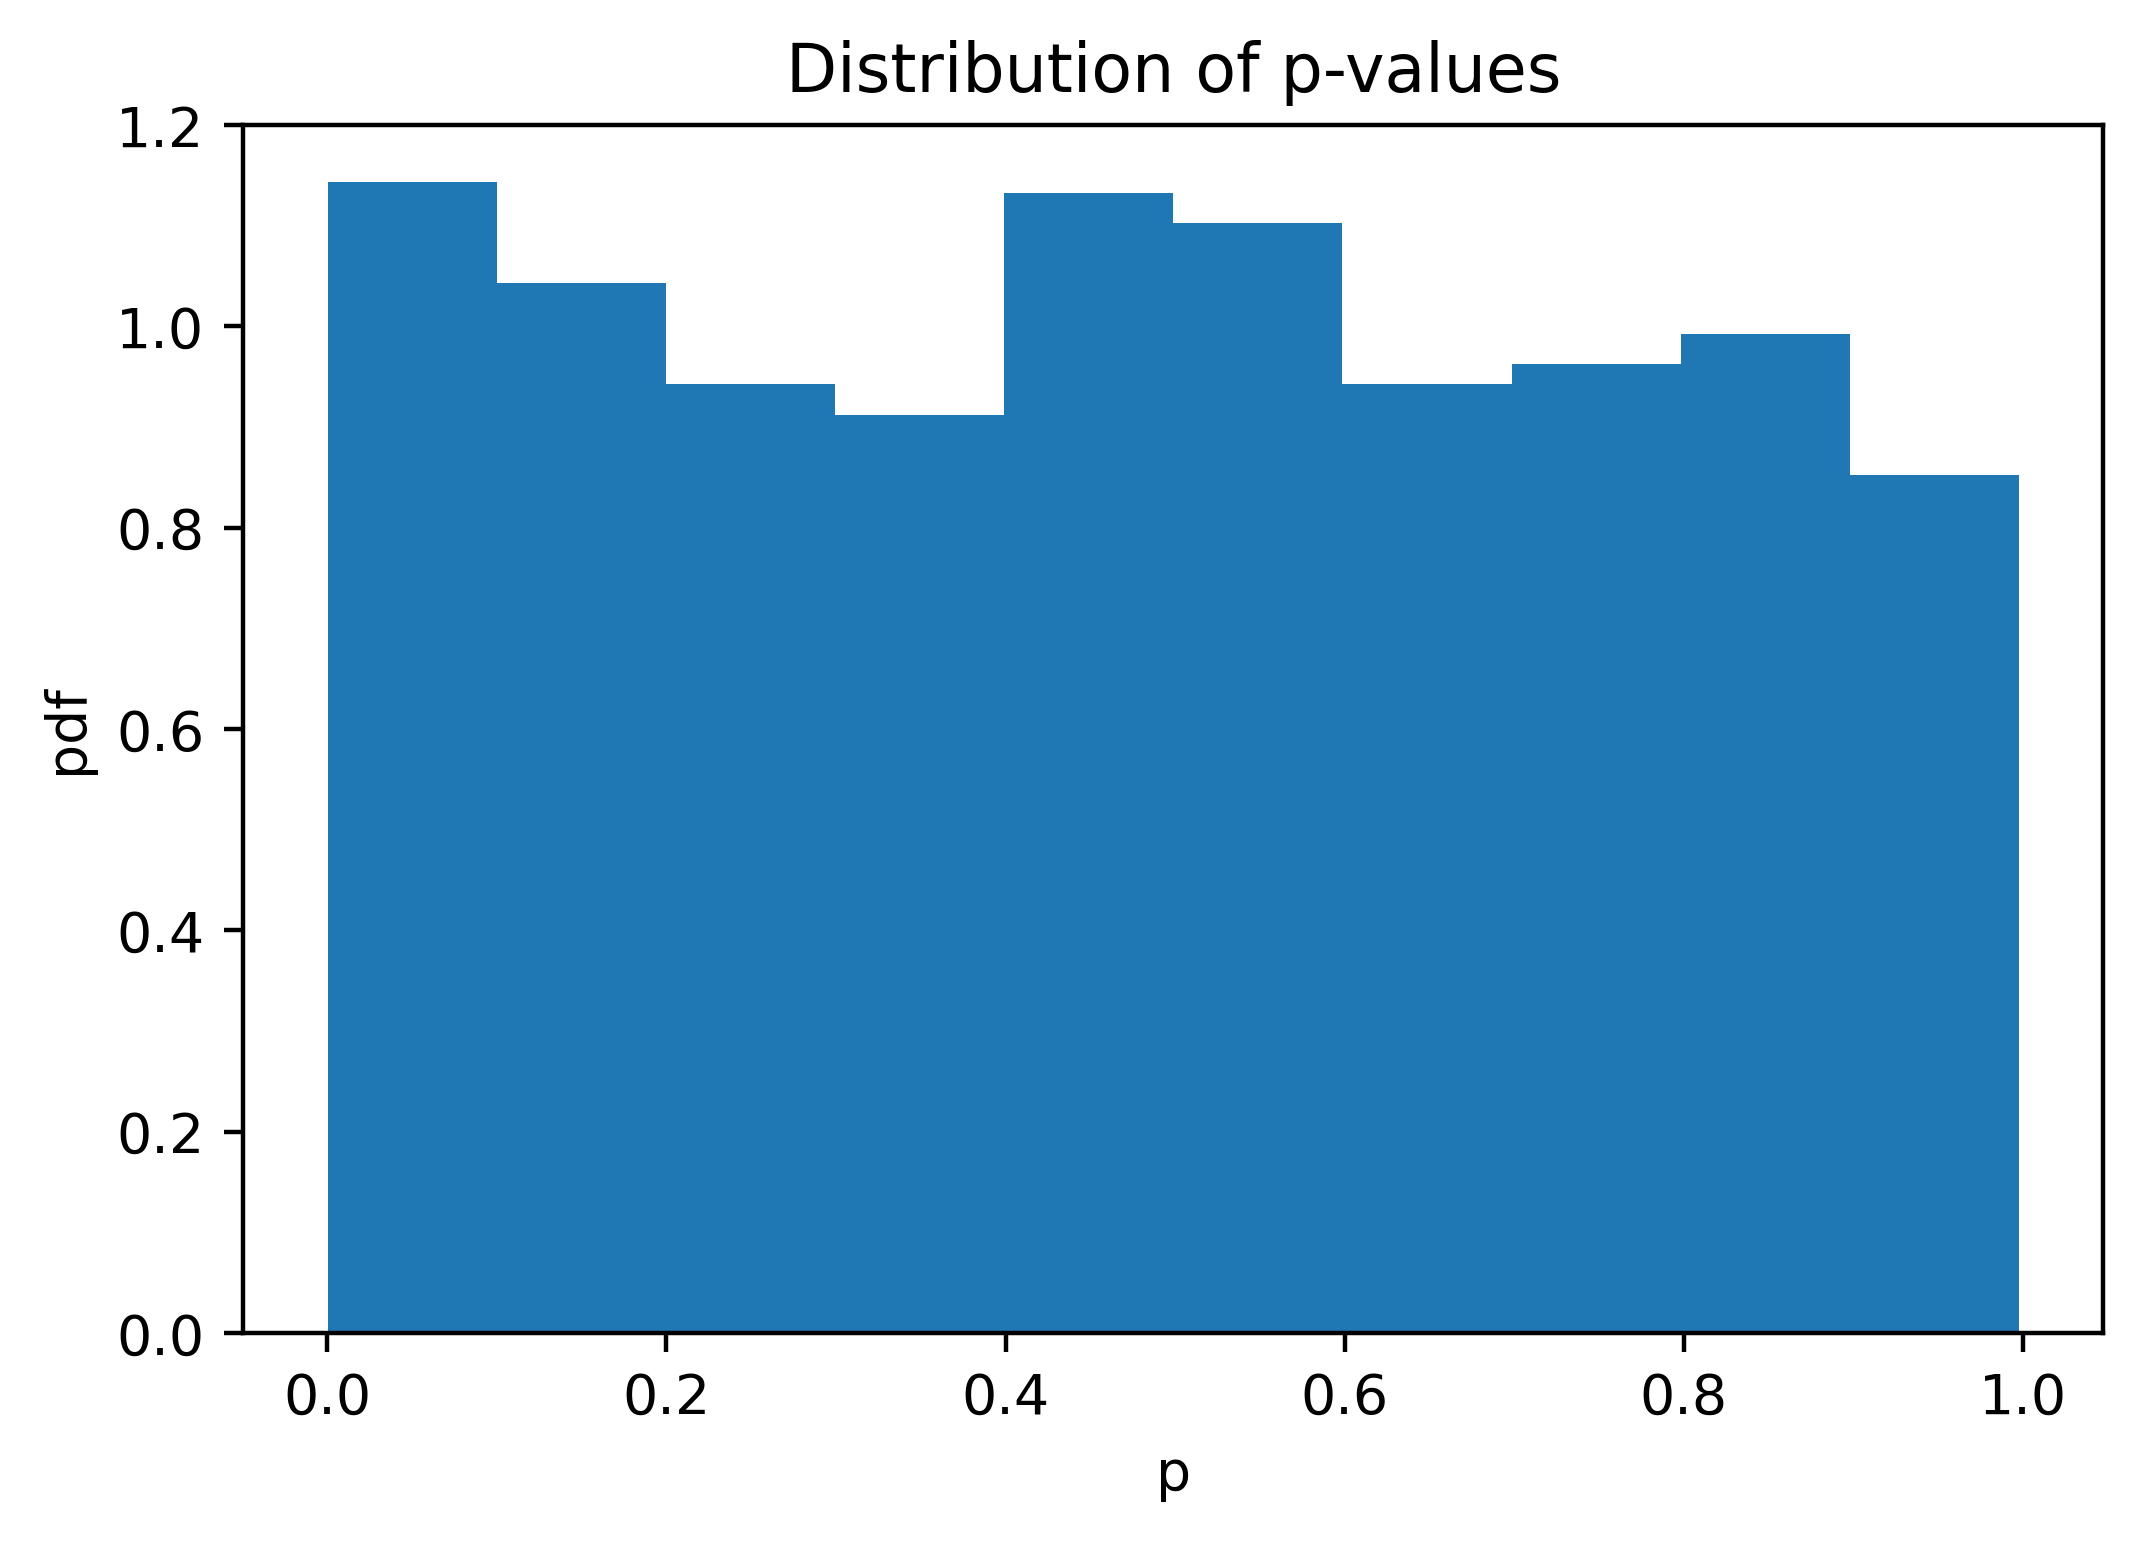

#### Turnover histograms:

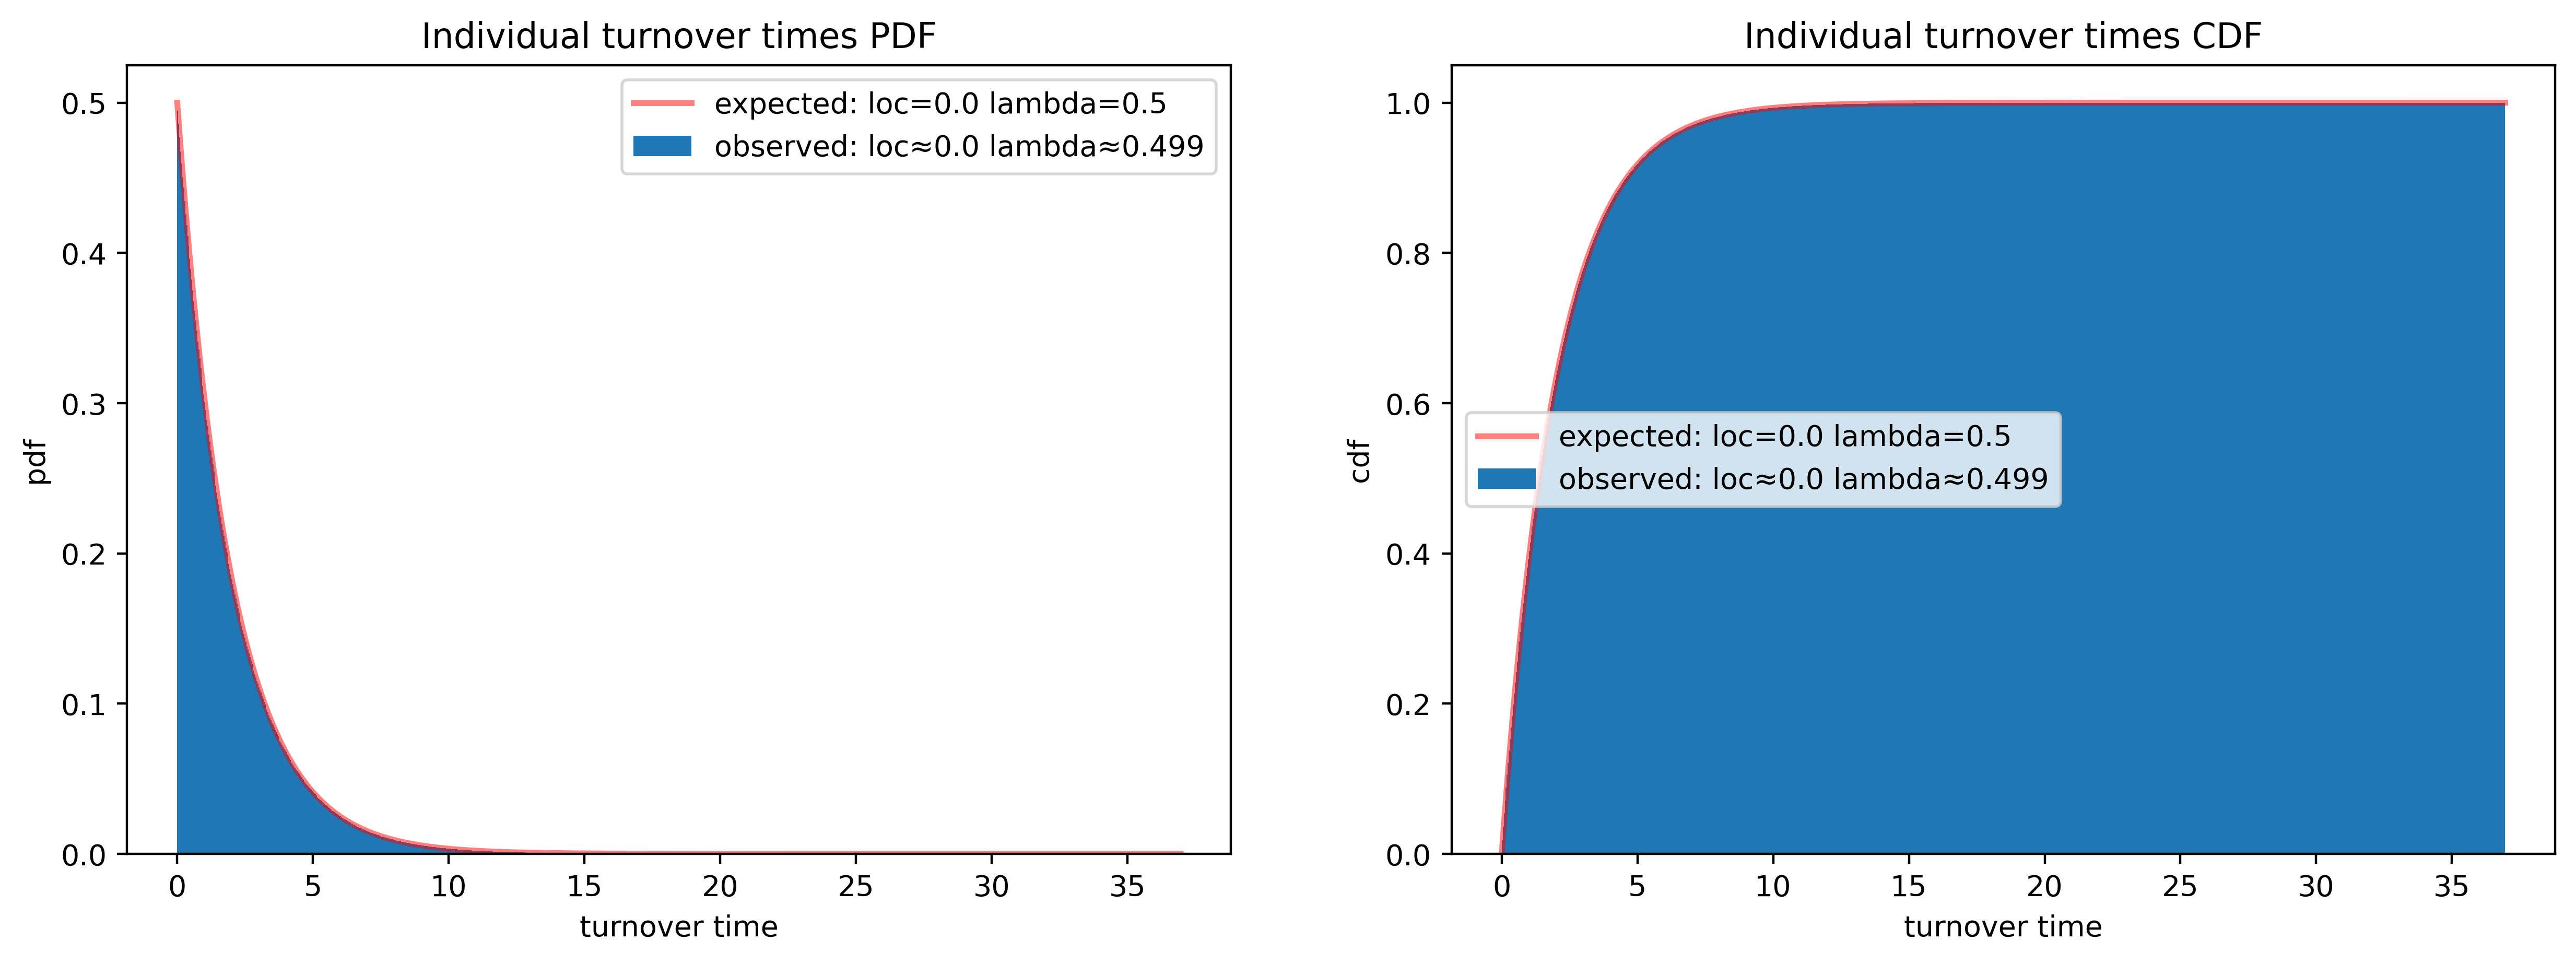

#### Parameters:
* seeds: [10338819606792345935 13930970126939458627   359072371574989574
 10447415122525738101 10494867834375346900 16052538633694292785
  3389212373304909233 14023916570955487742 17304108020150814029
  2034822036370306601  4601699312187972432  3255583385958453082
 14388623985986944812  3230158966174329263 13647304068277258401
  9463792212682694882  1553207999208622469 11096327430687323382
  8829281613137604326 14762963926203398104 16447230104881143534
 12213785519607880267 10689577499594592733 10502998697829316197
  9352614754937661938  9684251426270833476  7050932316352698247
 11105375378286300365   247354637158791089  3003727466709431180
  7208161344865311118  2625090211368341824  4394150879820840449
 10446043774347218285 15267962053747123471  9395423927463421355
 15698904040384074920  9750126756963530513 13834708990200127823
 10000977413015646643 16300150983784745418 18191200995702316687
 12588922245032188621 17092271223024640229 11924366876255563420
  7227467197784587073 14164264523212917649 14211999609600246821
   388758766102388932  3452031336660686052  3324269554072771253
 15450894102233999169 12208518293023844241 15391143589030523732
  7590051250457573976  7548211668502213594  6563820194982575883
 17805787594847657581  8877875725227666008 13478533103803147964
 14155342070227634552 15734932663640596340  1503528597542121178
  1273770218873524399  8191373818666771948 16266898464492146032
  6476615476747405395  1138647513891530979  4331788103329560119
 12859602803781061041   810196679456041764 16415868434656517971
  9525806741554210452  4987244698542707365 15733809374823012161
  9807106539614051385  4287286879527691600 15344141437789157222
    89836864963635561 18262792820963171695 18208133343732039193
  6851184345548571956  2400456614239723955  6983673109798765864
  1549090309041863902 16682558243188427501 15128585166911834754
  3924882394763435568 15700940916945512821 17916789282923086084
  8433437332705897918  2416418245245392585 13375369402374022518
 13430428444645889518  6760636217825594771 16848932662974067082
   994833734857560896  2954357458375479177  7232391592911708693
  8104253425203259828  9994163743822854583   721598548550370985
  1053978688491872357  7192693423734597743  4122531606265482978
  5229462267277265275  3565951725035486640  1043879119632777715
 11776521616814557087  7185850938208314151  6151735523118464404
  1856776020696253346  1711269012806392560 10125611559184682631
  1299749063057817432  1351138332334838121  7606010430548002491
 14235751220255235648  9967131083270785156 10406527434232595729
 11886790953653152030  2777184217349132923 16273374618123178807
 12752168108488238971  7009448532765338910  2561721764957112339
 18143045799751277338  3761882042950658920 12703745009641645535
 10385057540725110038  2883225193782466565 15973188309651804369
  6820911137804793572 14413089634798549381 15215383158078959849
 12715993722420480190 10773295874155707243   282128436828061403
  6246467168505168593  7049560628828432424  1022599114836006157
  7022804843384812266  2006586705766071373  8752473306274276626
  4782232979041659304  3242171531555753929  6287256176258287034
  8031855475766281836  9142999454500216153 14114923419969877292
 17848834368329759226  4766230176399810534  2014447344504597856
 14187048794441753230 11446841997554905512 13337873357578067706
 13642068510062753903  1587571462964596466  5425625948153272947
 17040771506845919017  4842207084394243973 14792703288814226280
  2959973441378791971  9725665760580646873  8152810545375569337
  4532562174223648218 18123809163585831240  6011615440891661534
  9657218651875868826  5425396816629800540  2921568122538986406
 13437507981829652377 17704565624441760560  2397121553880672231
  9194807431181887253 11556331207004274269 15029689574233697274
 13506784829762634315  9307559786307136294 16377035364097653763
 12701958468083854086  5133886500862264982  9628164240118381318
  5106444142560905785  9221854704993108841  1731574241562008340
 15594330093660059549  5047349148651762481 11160789596535042631
  2760422312661482593 16410805459765288177  1586146744052902442
  2588019148229274395  9182850162895849206  9092690469506729879
 18294694544598521567 15329058325412675347  8817615512648435684
 14971475560766158852  1011588134789162564  2204838881013013782
 16820450903023940522 10380003049255748416  4321656182834558150
  8243765436497070344  8140187232268290101  5570696221813003551
  6943725169958216741 16590243340492077368 10377178628359654332
 10977405766795335847 14843540985970673492  2520940534315168491
  2966433367214160569  8643404482135962987   617561292751438931
 10892807044975756442 12641320106514776845 15500124984572677683
 16346229399672171824 11775921953237853725   430731852917762019
 11890814238325193484  7260995880516978317   828654665311514306
  5448033931556344669 10902135718031248055 15477208647481895559
  7042235991963700272 15491692473452876987  6943574212162937345
  2795197473782209319 15884479374429303457  9524378102616934711
 12814094066198798439  2538363297617841967  7473913462247813290
   622748031785433543 10401447452274626769 17740300607949251344
  8049069286958069815  9647625865260652748 13800885385380525420
  4680642771510942375 16044680141618243865   182285153876778985
  9272581959290221617  7240231881944022925 16976272530926350924
  4206224166171081498  7289770989806978397 17273789486456404366
  9752245642684746015  6791315266480119723 13484937289497573238
   274823199658779891  3520324929269278845 18278641868844076174
  7386615108460766383 15050702250866094030  8460405972192845094
  6519401073094938370  3601475363347546631  2496410233044872605
 17789104035296931425 12466817390983061341 15790561753007340407
  2861752364003321138  5542640129010163042 13850822684886813082
  8368469502643705787 16826044453220366088 11571064397362034417
 16198417597484496865   543217826081394318 16351210267594030205
 15144501347622235600 14675093585839073145 16656754545407396420
  8388998208863752273 11963484739315609935   906630063750884921
 10224316618514691357  7599214023730486347  8468666929320071331
 16367713870417419447 10363761002411576841  2193698103390557699
  5226948871516553808  4297370610410537093 15759261257352147762
 10829786993032647920  7136540330498740425 12574445684227018029
  2347381725933209082 14259425170737676356 11272016987383954095
  7536249149564360252  1396464080864155222 12746721625101744270
 15252689677219060412  4590493539998202358 12756298709786917869
 10611948299417948076   382684407170494035  5224099032334484396
 12894900822533345225  7693498978198454964 11101868262329481571
  6033468527978085440  5029125813232417611  6928124020307641829
  3454597722208864679  1904813633561709747 17232507344741237385
  3006740136817047632 18254978505777604155  8062302823196554628
  8298727560481994943  9950962713936621755   895646580100014391
  7123061020588508970  8939265436494275711 10745113998507363623
 14285699519015461646   166337884664439684 12461621299952011579
 15390472723535424074  5741377320707397220 17877367756250877986
 13996769657213592153 18036341083500724076 18013075852145073668
  1298557959731774855 16358000070741775188 15599781851227705340
  4919351263088719402 11664015601310979417 12632210979223728585
  1113856722006229233   524364023758413009  9479417727261484166
 14282707872044507499 10522952030448750683 16622312779898619663
 16778846599730666972  2095864793263567585  3646570921483186160
 10216777803064683319  2818249251253281716 15747122264214299213
  7078949845987904512 11158485916465910740 10363113855900980245
 11660226847036356615  3939484030446915164 16684759389437725228
 17640470106014990546   435189940566014162 10387035896960500736
  7294980109749638002  1007464104065055281  1456688888283895358
 14051801053787202047 11871691224216440564 13874049657898132146
 10354172100428756609  8210560943267046335 13713715893140702348
 10484214080345267056  1555164361005745883  7729951793730666538
   722872048020006434  7434655881132286086 13998803778480336795
  8656386046252503658  5193108693396524797 17460826081023241343
 15359591761826777144  9590980949873930393 11880722375513880794
  3070868459549616274 17191419476370396464 12792757660223888473
 11817673207307024092  9221343429323610081  9841048049444842718
 16259530707038452621 16374743172612602016  9345118870662698019
  9093137090880568841  1610878202686156818  3845871106097913987
  3001858507831127943   839642419583919165 15321915327924515784
   360118124852638827 15942035513190300147  1068421666029054572
 15758920788489084643  1247506310544101041 12232392310407789120
  8217362730683176175  9528965984860366748 17465347853343493176
  8823670561959305839 18142602104529806638  4053706831252762802
  9522007769364064612  6161488700041679652  8152620232482780659
 12610128842517039069 11145393072402747349  8321837012451470398
 13826574815876984825 16831037088844192404  9560535636426580917
  3652529461215045515  7089479562554216172 16097477709778535015
  8317618942297825475 12459331344666978469 17411367922441909820
 11805953769191924447 12377233666235739633  4864437685745216040
  1295394996228063054  4397501811273174093 18331489953974409498
 13145049767663849282  9491371182891675567 18078924158453680750
 18047232428927288878 11401894393972838430  1821602418778046168
 13980647861776477760  3134319518183579936 16446118976919920802
  5315618896519082890 14384232295606131456  5092170298698345795
   285834588887383591  9384835033801080572 16101954059444376891
    34664699304280369  9228660224225549206 18201027232269054145
 13726946499515471437 14791042799015248139 17979685811292430797
  8590002773313224984  1778975884284045755  2490738108097540221
  5699328860848656658  3716042657762439474 14324153067710501422
 13353930793835328068  5823042967678188193 12318460454379092272
  9871926449466236534 14520734263896168994   608114897033500476
 15820172371479343509  1358433619214278274 16394066815730133966
  3996000302964075460 15235177103845512976  9963026400132483579
 12647736334270130341 14371977650693683738 16378161001236650337
  5219892025834073322  1509151703096890702 15043945346543004862
 15909811088080657016  9960475114902404797 17522916810942279000
  6530890369147659828 12102122858221886726  7885530667064216876
 11388154510930025066 15120488015982396584  6801512921372014582
  3564011983963963375 12502473099870212686  5872839267103853066
  5600453371636806287 10309269712270471668 11385644774234455822
  1062563866754879188 12115932618434226452   458772671705795723
 10018402919056589365 17661078175439285564 10605509908987300955
 13201949390062133847 12750628908903471231 10172137709351615987
   413154887706207955 12961842950329879242 17048290621615449683
 10155108830112890380  8902372008136300452 14577439312435662273
  1440172005649560645 12610097789858103746  6697163522286896120
 10103625477668662017  4422850543821477920  4510786942267280075
  1779464530719346031 17740640908956842141 12276040414946005583
  3273851306433691660  1715562919777443465  4324035951891524877
 13655203463582115328 14599542309750133707 12149460289705594937
  7806592381321620162 14912807997215609126 13826562720028300691
  4131025249659888828  5960666335152821538  8684748136044949865
 17090116182539385406  5216147126590453852  5256451953023254854
 15217663973191021001 13010735587152378303 18334800772840663276
  8877649403504632316  7802001770550342419 18187062048249422936
 16455587637351053625 16702052320997799278 11518244088144136659
  5730775106350377180 18228346295882287339 11708423015596462250
 17033324722704959487 15312541977523090429  6331252723217195868
  7943965730439471081 15413383299995625844   473078318692024465
  2106355950984506731 17189410878206679855  9074604844530994026
  1692252922731514478  2505389628154545633 11144428720999443757
 10723323078756606418  6657557415928528481 10686929648141765378
 15751384360842268548  1393060129618527217 14817746362586913718
   862417931924751809 18100563818852039945 17945306578382622205
  5684807350394546379  9114727848363603820 17980961012360889353
   852538796975259994  3932154169802863444 11297181845936268940
  9667554491984345750  5567712465658054511 15147410676819479903
 13467611183974934424 12536347918670566245 17406300654662262759
  7078782303145653442  9315559299902031640 17055815978414151390
 13244270128882331722 10493814769968534242 10979500701928153107
  3884896179920526309  5171357017296954534  6399675371567438361
 11455130094191939650  4061775965667074556  4287188823833779325
  4203237821991376507 15490320864302136093 13486635411675526339
 13559149196756664201 12784183404790410863  3723651567487857151
 13030812286025937611  5040161401726086755  8138478036393454728
  9424144438226714826 12968138953196412302 13666505971587386943
  6424666661868219249 12371787848368788763 12655078261262448238
 11282131813407080424 13664512276513692461 13084287957433683224
 13694999757145624198 16877082634291559028  6706218572721474474
 12837797994333734320  1610323557457551397 12850219661514007319
   954906705685430889 12864987289313241971  3243912191087341400
   712423600989024095  8658935428516232960   989458146266233802
 14006428087623635368  7268280812269422896 10257816019934261196
 10674647064840810902 15291204990038044436  5615987870947761183
 15452881944991937077  4459660067594861637 11789297152044447331
 10356189402266377516  7751527086630503375 15977248601532076865
 12831300070465792773  3625749968152923940  9769051182835411273
  2862859650937770326 10191299998289276439  3231739926141433928
  3688213707933925998  8832949136064536053  2864409236384359951
  1982123207127034076  8793023705425356807  4489701154675051737
    17264512366777556  9173495015005007529  2685515896327628542
 14714507510893419979  8356347429460927988 18281757978617726741
 13381630521969133594 15781072808976009552  6288103768585234106
 15248479004878634385 18428979402727825464  1028231003181663825
  6633036952340520267  8764982574794907908 15749132093169686997
  3076758951869734222 15142880797635709077  6199925189078579688
  4643916049107147374 11461659895746857516  4122237185444218461
  4846672870523946681   630371300926110932  4347572256106619349
  9163822871385412796  5948664852857645049 11085565760855566093
  2369044216866518002 13858213745100456423   683967182660452421
  9073196080732983041 11303312877653393292 15979757752582447791
  7994432751196390092 13165226887174927227  1570485690048615228
  9657198781433434344  8618285659331051767 14490304638815355625
 13349830506363976113  4854010765282430895 12442544453800236447
  7047196965132618109 16518301436282753312 10749109057992896572
 17754349030040218359  4229411400223154598  5323823478523650425
   127588342715077483 17389659440319502492 10750723565021690709
 17006171769799577867  1036859258920637944 17600237990403496071
 11793068118208944687  2308053449931307714 17715280425276366403
 10189491600557446437  2786384884195419504 10173708704173263553
 18311381081391840591 11946366623306575474  4578235896580537592
 16483080166744195094 16707833311322738648 10407979179108389653
   581346104000706900 11839709101222390844 14892777642910882733
 11576749046794077976 14167060612985909637 11248771131388825186
 11670044228898631078  3261327250461055498 16389180291260111360
   394129581379533828  1198518130617397197 10963404237816805609
 10525847805379340330  5683020816144244644  4206417488375816227
  3125391960221401998 14048476688490373130  8940715120362421898
  4664217026792009105 17508901784715328907 17162856594937983730
  2692704015062613534  3708995846041230561 17960946169040865819
 17074442016751700811  2773770535556109416  6183078323470610952
  7191677903046798744  4615838655183376366  2004966647393957903
  6692949459323341794  9032903272725360620 17763932838914521812
  7822697225186121457 14871005958778616843  1728363185166711311
 13952294493468699794  1419929019540391570 16967747808428728095
  5006226838658724635   438047231068332988  9634284711863393059
 12334118770870495489 10405437259645663754  3690435404409470556
  5037333455771439633  4519021922215477037  8692686575856673193
  9405656461267986841  2222563866646015356 10473860866126531566
 11574976573323906975 10917606000187776238 13083745583226495065
  8157517160174937957 12914887094727651888  6831788650201285542
 14248210404354855026  7128743754051302699  9586018710466936845
 11890172314392674050  3740335844942755121 17541731328540399593
 14123042969653320743  1830525054967171571  5932314874424833382
  1637591644488722696   243109254209641593  4264038702218309202
 11334227384332798746  3942845870546108286  6647520531829826052
   270393372369276645  9915131260095588133 10433778439407052480
 13993281470187719212  1639601312628579261 16184178290383920990
  4273098262964828519   677176232439586449 13193220383037272692
  7083887075898135406  3938552551526704246 16142217243674517437
 15172795915547291166 13994736210002124755 15704172058248678388
  6256758823721629036  1183344620042198914  2162579598974012804
  2259097055387851768 16340876527187055678   873440798303377887
  3281409287178337257 10970285128697573946 10309697808702404738
  8915269107350935953   679306451106799951  7953705581867538775
  3276148160359948171  4555737115298364501 17294308678202943024
 13228583102582347402 12508869092593118377  9894851133188198054
 17332609466751822198 11775929386227353099 12093217093597865146
  4020576438395394052 14282938034300138264   505242560247769684
  8863491668278784001 14085583386511570109 17174854545707956897
 10898582155184338590  7219043224411946516 12473098547915882018
  2870981464253840233  1965895215493901153  7117681227420120565
  5582218291266852258 12137038759293821034   483843261906459978
  8897291743874579211 10226894622289388944 13992324951350227000
 15518909357966856730  6119414580703202760 15387013625341598972
  6470653768553904651  1008316984062317729  6364046103338694348
 12594441292623822619  1020188418190829352 10298172374826127360
  7732924942742425069  5665174471130064758  4108260968523364169
  5017037238170400549   297586545308968194 14918407010451395776
 13009025744229265175  1699013693974605257 11725888341123522165
  4916771192871190438  6633034347262337241  4534681133349748285
  8288333299915826151 15629953552959836938 18046590323882833625
  9038032131616368672 17982632351895956902 10560844490599892271
  3022943520265581798 15585115998029183622  2277106996550086330
  2714511865889373687 15113104415363126236  7499337166159117894
    26336718399787575 10853981934195982689 14326661081157968575
 11344482368601629247  9450104921118086760 12882011733088121743
   479559739837129792 10490145700081834491 17097894215938549737
 10812985250616157716  5917640449202386105 10951301646427480468
  8579420390506727757 15887568613425003217 16969746202894502845
 17136801835730269690  1337898523511701084  9190408690887507681
  3857977967070206424  1323920599876639061  8340354094188090992
  6610651882029590923  3345163282496723165 12637954134384961031
 15537244514416470216 14296969228372638977  6548104065587009035
 12573988588337460675  8306530411616129768  3405400134846445620
 10301377602616378708  2330142325858114139  8404479723817225574
  4382280858165907043  1899810409229784503  3095642223702406511
 13895601601724444450 18025083607737263532  4769974120465214996
 16976624572567534036 15187987409398875748 14637668730604586490
  1450749563929402645  4777202262722143319 17363751048929697258
  8966308847092411519 18283696859478865769  4310175446212268836
  3773162788592136819 13200388654600841682 10521289070274785605
  6763151756736558721 10395470028042461729 17049191483042294091
 18060263018830898741  6269632915792982012  2027336393342866915
 15215340965556529899  6410714883604457920 11136164002331418126
 12297339600147670158 11552044088974589978  7599241784908031032
  9397391394792632427  7855011652680700137  7537107700267296080
 14975831054510239886  7875622241631359721  4719851761496559867
   637178096129000230  2541245158331194673  8582647050469663460
  9357307347294341281  9345249358278235141  2450208765776452606
  9379329046074047860 16068366542394435933 15896872708346690658
  8470661625776597630  1222872680417954351 11728527823505035166
  2591966932901441842 16782313606859233348 17655504544964035300
  8693752660334605729 18404116106880139831  7533277723731711992
  7890624705776960866  7173543569152559825  8293037363083574847
  3033213444913951395 10202060997718569241 14097567369500732702
  6234716005058084860  3515790030518613884 15235344684605114666
  5131696914100499404 11726471076719712661 18087523741708877229
  1791284523569877366  6537532533835397555   643031305951454009
  7613082276970116544  9824823293795375601   304829435082074502
 14176691620038486987  6138528594809194146 13840131835438281816
  4839149021668032809  8075346222583961975   905502101819602079
  7858886826992996533  9035285431949176016   356106005195631680
 12460769940970488586 12830148462995590808   186491042553181079
  5636803363172187568  3108821025855126077 16662328208004861615
 12587764745462145860  5686119453716921505  9172935403113933525
  4039850190611057614  4826531793110849610 14264456900206734893
  3680804082979623605 15050896183849825535 11507793863390433320
 16803809965530266915 10622557496387157199  3978441023876745746
 11767483251688743540  5872199030471048759  3026142906452193054
 14584817570437341915]

#### Configuration:
```rust
(speciation:0.001,seed:14584817570437341915,sample:0.1,algorithm:SkippingGillespie(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

## <span style='color:green'>Independent</span>

#### Fisher’s combined KS test:


* p-value: 0.22743158617137677
* statistic: 2046.9626667390814

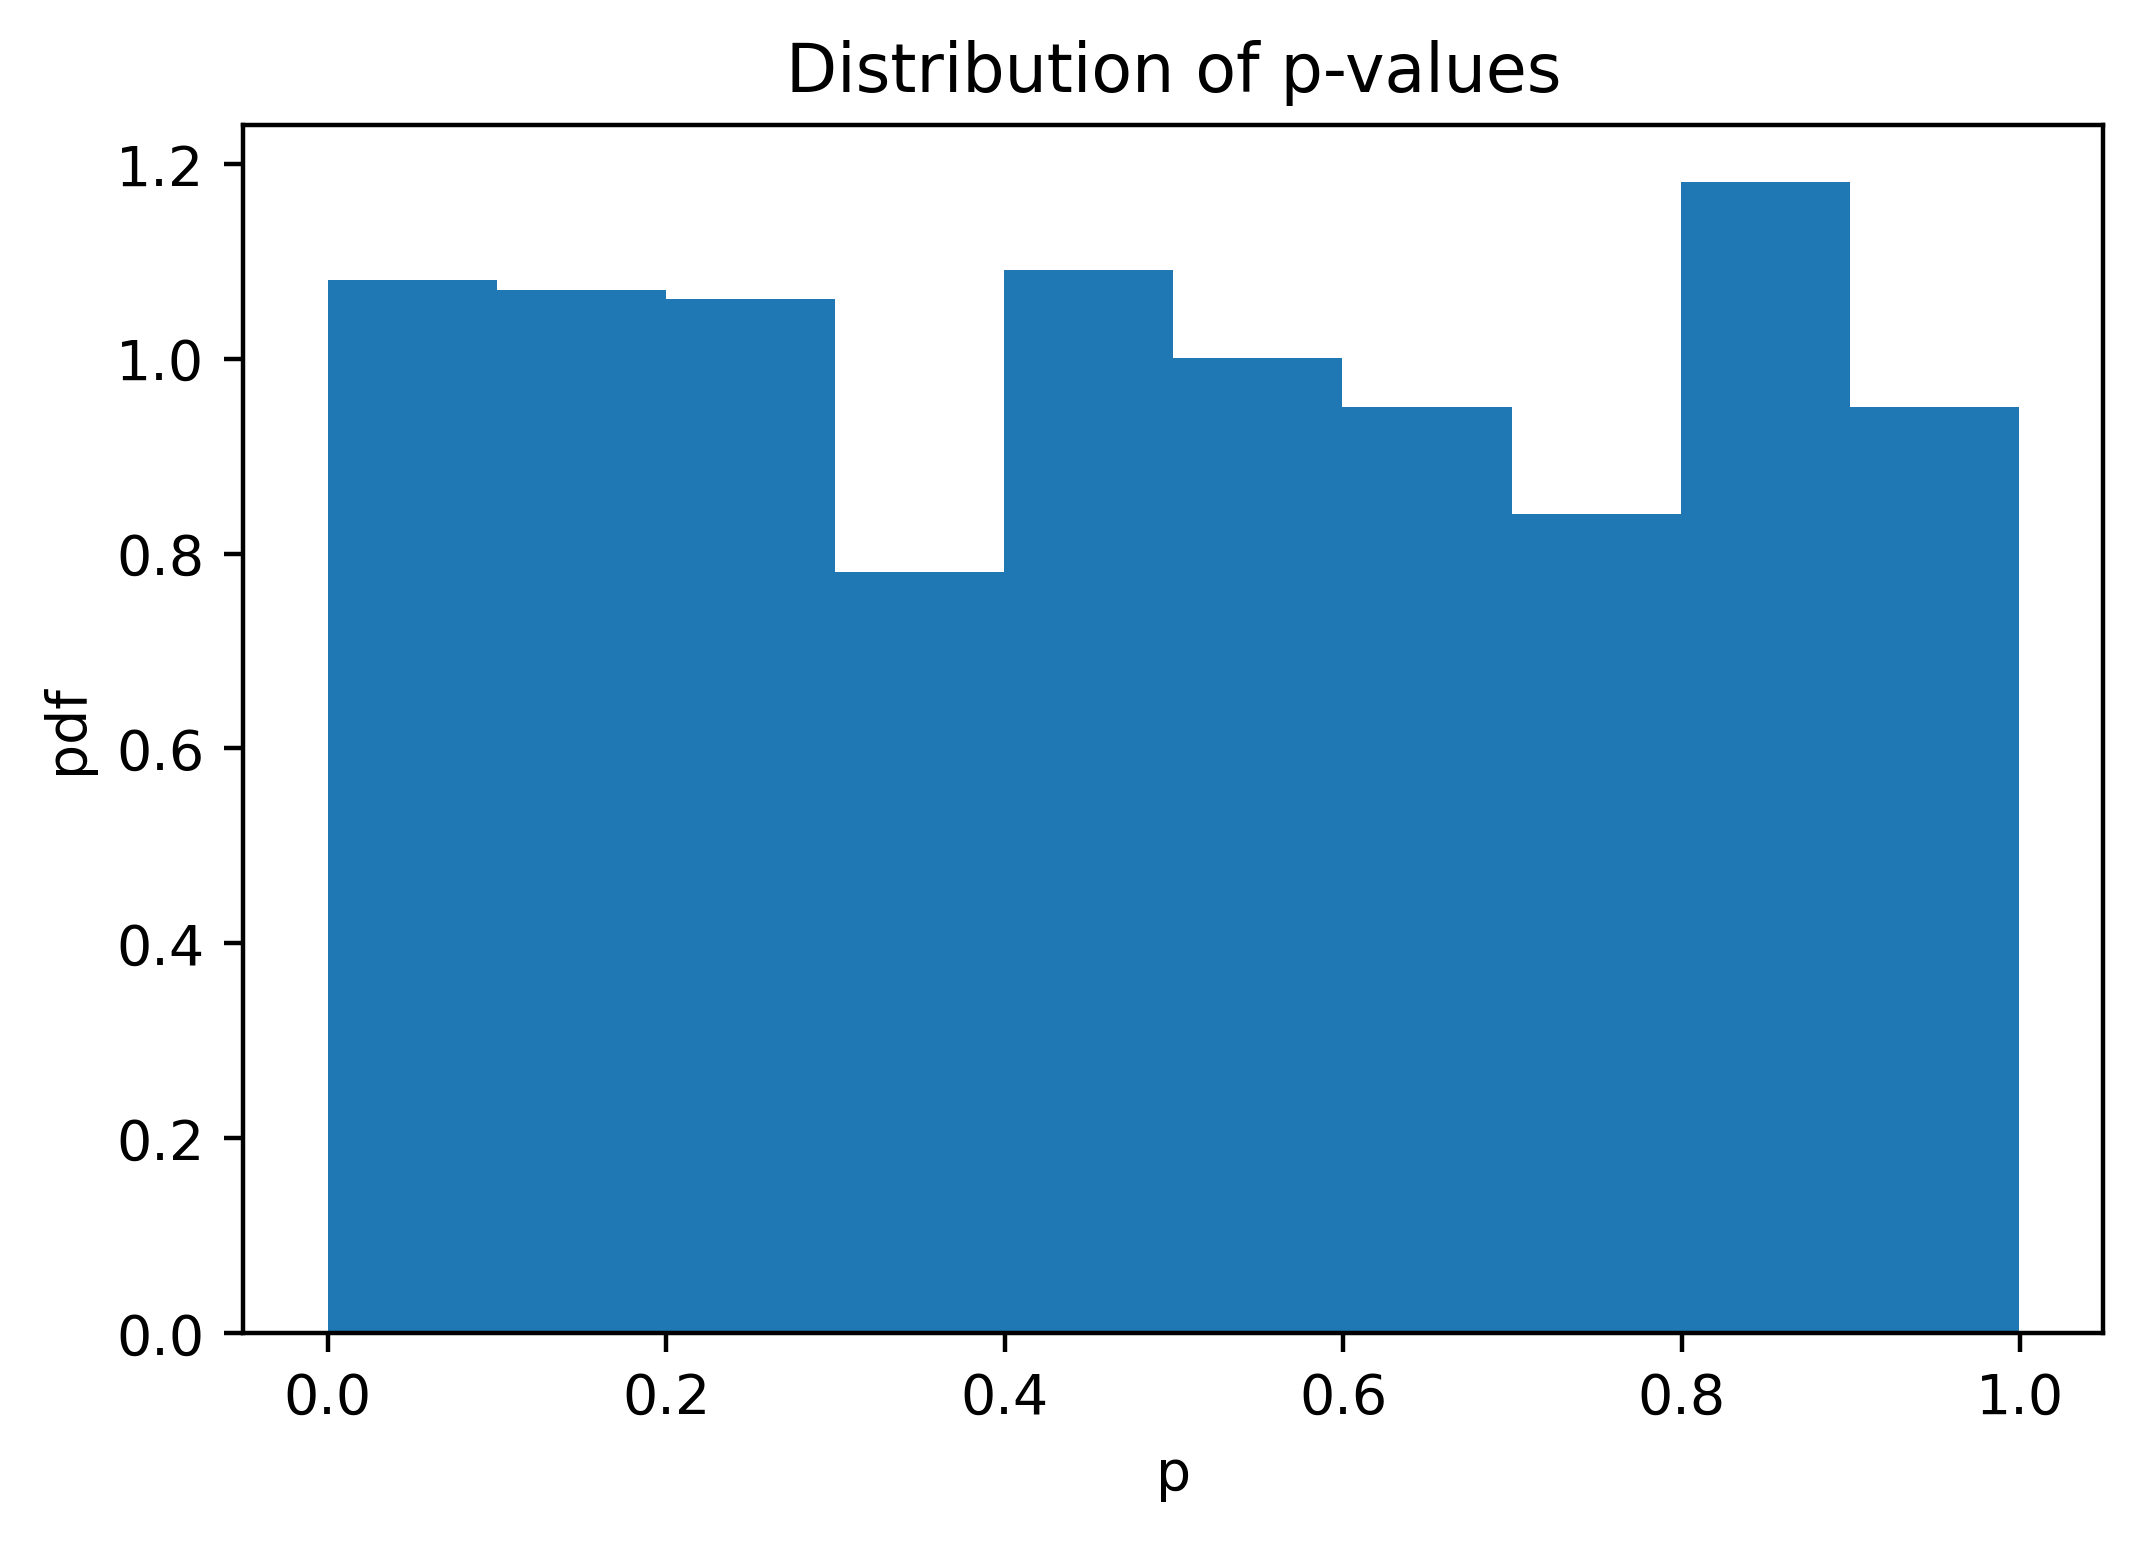

#### Turnover histograms:

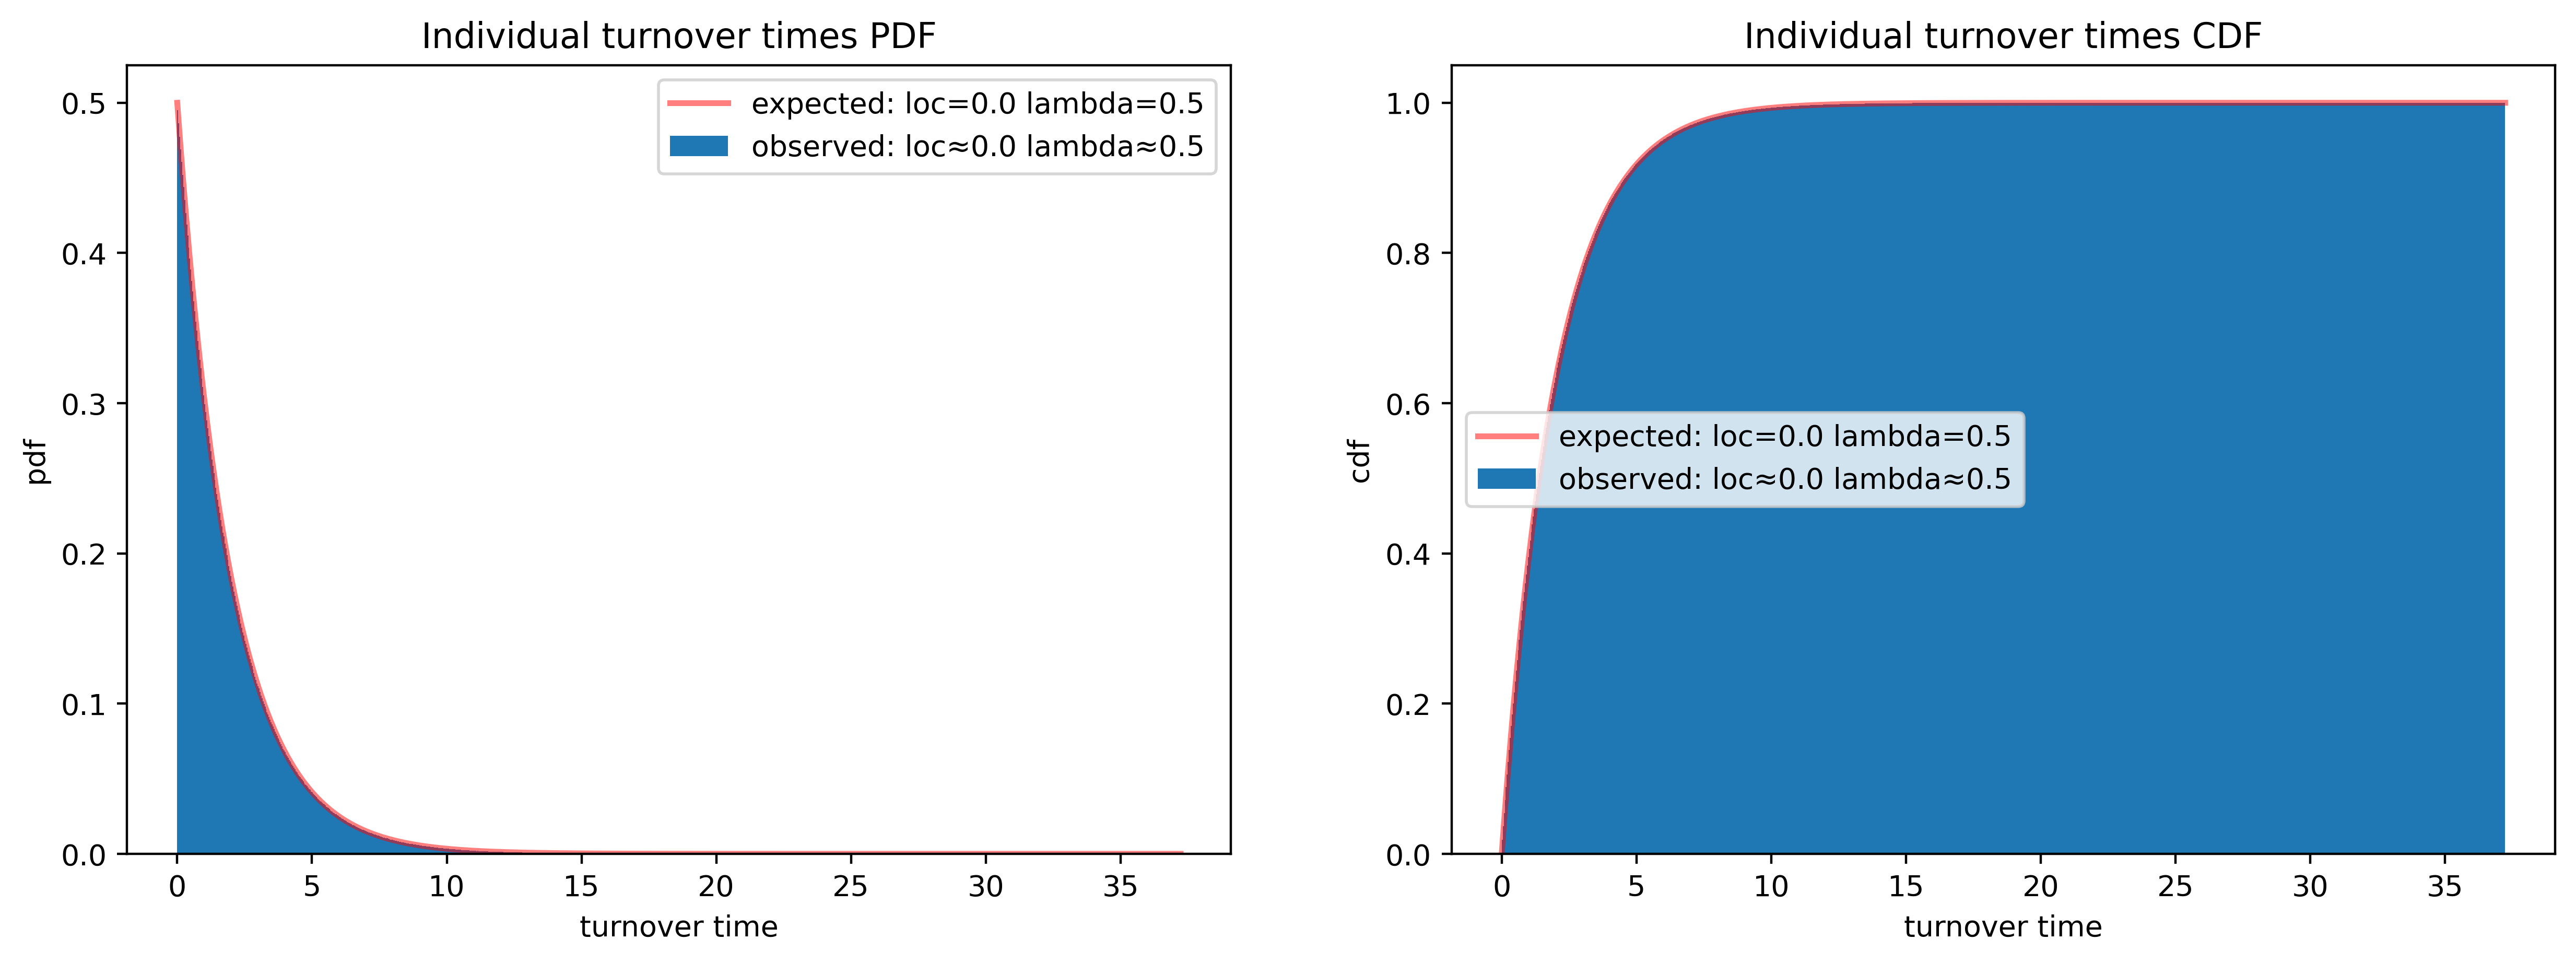

#### Parameters:
* seeds: [ 5331477995341498603 14711093921406818886  2718301350438459786
 17765566534031760179 16963294766951469383 12251762433415884801
 14039734698244104697  4667146352264386840  5979291699467015806
 14147807205635918077 13382655983788880304 12272411801223645554
  5782179912880144180  9438548424823366163 16485528656719431941
 11976808701284101496  5071972415506410386  6443366527240934921
 18335249987100796051 18114260341573426873  2067441917474151326
 13191359902022603502 12381220135015468179  9816780562248882805
  2537150199968551368  1524894431038762497  4537595175658880961
  2502383416396601519  1286984955125947657 15689081230733459716
 12774778517213474942  3803602465716796292  9251481686565289611
 16951847275210107359  5794302595488355314  1576292785109321467
 13765751720590626271  7094249377682339009 12377996320881865359
    68467913677902323   384701235984583684 17612266052941215678
  4838492937310846927 16294532094327382950  9710286817279503753
 15810986262681418329  2931956047259703821  8007631137035178555
 15063131200490454249 10507031711152673733   707561127285281178
 17624142198861469953 12780737564855372981 10682531476585611581
 10683401150273737233 17757836159891507333   975490863929258516
 15742054097875349163  4628880086489228657   803338742629531099
  7346151431225869717  5987907025278131292 15597703171947332893
  5120229632216346568 16773067173709623633  8300353696623638462
  9762620061883595388 17182984615624818735 13507120449432642599
 15905400668502043702  6461597487860787749  4274041723792177910
  1781250935054949311  1796023221114593539 14523183004707919515
  5420485770665521242  5148869240525379351  2257454677909290853
 17299306234983961196 12406596174495977835 10859546142614854722
  9347047298895831144 15271742011377526400 17868079092740887247
  5680546803367310227 13936951527356646548 15011821103139867296
  8618243432050854701  9273180146639662419 14495412923835375945
  7082198036672429068 17887480907405996357  2585237589873537044
  2526107702706742235  3815091437119250160  7607846417217229697
  4828641618405429623 13008047703107653911  8776878407055831650
  5849240234036303121 11964565858397290842  3577094041756161429
  1024675615268328602  2154302486260334594 11845255129263368543
    51699816509267201 11105878003751478129  4130090943104861434
  1475225350263674219  8752803102190463192  2226865593521395959
  5016059398904062290 12098360937326646358 10939135802955599954
 15956102457757651119 10535985508989997910 10645373510997720850
  2585427295934851288  4073104439503868613 10325370471817826689
   277905456288099553 14358227322493092076  7378714907474607489
 16071501086155941221 17323128928831794496   868945860318096790
  2240256823019307725  8096444686635382680  9076047675315364341
 10598989974415223351 18010280285262568965  3880543951343428647
 15429908956125369767 15511810495853927546  5201593388035037071
  2332936599481740721  7672300387709216228 15924399924608391409
  8936620901630508930 12545789642163128382  1212144286007988443
  6387422121972119639  8222076013384827042   870226209366378902
 12655768907234735020  8652137897786504579 10884336987873585314
  5993129062489287663 11708288590052200810  4133664640215098067
  9900528388424059081  6722895716746649226  4810306766647121005
  2321737956142512665  3918026342192837803 16169790432873056895
 16356091133920165732 11197749324193573412  6929561609014160314
 12098911176632060004   307323157755722028  8534977151436867733
 13825126537055572799 18415850416058436073  3682631108356491365
  4066938574942134932 16455434691687760034 11375268435077007917
 10977351726397367862 11348223293759811337  7388181484590249961
  7212078166118996477 16496738487846203088  3026087329872122722
 10213615996143829463 14131628986650751756 18332754079719039463
  7075276888292574448 15148595481084392862 13143791556503453868
 12024444124458477695 16584492265585833189  5694076650067276046
  4353808913756875687 18057127892710569230  7975204770540194806
 13078183288940062809 18366923030609106455  2016635686592952773
 10796029462238581014 11791482363802399525  5072787394521613039
 12805904420045461405  8263036536774761746  7882461873875151243
 18284170516736574055 12703977144252701021 17671544224165723245
 11086600847565511407  3273727158077477462  8936777315114244215
 15912697033961674206  7445200680595191898 10429695201092101499
  4986793253744397612 11332925097423861796  5379180790103310970
 13223527892718473229  2394793806023763646  4654370397078474632
  1113110153407119100   367871360919593381 12375167091869457469
  1941135157029014898  4871299790217930388 16714301226699053135
  6599766884991363040  8535552472333564638  3939498874429865686
 13547509564533133987   128575609676962715  5478443221963020773
   781217448805596517 14517900133612533355 16675851113237368587
 16534760724554557961  9177524617817811788  8311928802535635420
  8628089945494582741 16947315005173394295 17792304160346440256
 12893561444423894205  7576129608956743358   378859150000813594
  7401504983534628879   287015494934898475 13190188819608883691
 10077494797032941347 16957591833976408505 12552466231354738264
 17999748606863652881 13215725422831026763 15637465321175023684
 13284452677593553978 10047319533200388824  7436687853229806870
   917278806368934571 12981514444023897674  3856287949380774947
  7424103102742897247  3153845786568037462 17556207954578385342
 17654836953094416449 12732106068903877450 11073673155941366227
  5734014409028991664  3499966022677744234  9321340810986157660
 15200259727324859499  7460991882025000250 16330715150053620422
 15040384212790343704 10329628998908913021  3402918613714330963
 12072905594554465523 11967461441291166767 14348889899224361408
 13125523908327039060  5486006272066144872  2907279688439483622
  7181349191411332799  4639100879499613398 15779085604570847073
  3239830069372621461 15373435987737123652 15023570508682157924
  9417639903274190229  5807780105672298685   724635937066184719
 17960490251021757650 17212788362941764228 16743308763909348530
 16742300454839962695   464229844136283886 15115195484369704759
  2586589200583120423 12239228044317368101 17824413818569638127
  7964607679284474924 12493006550948078876 11936668670847590405
  7471523015067967389  1845987733278449291  9555184080954901233
  8005422242215435251 12529041876672645683 18412154422399702494
 12359284938064184563  3205641851599620240  5014494695703581042
  6250207953740602133 10312441367813646895 17983363614450707741
 15634292779671236308 10491299161417406477 17074710186241730802
 17597508126752111349 14258619657266692689 17423802005123550916
   982367559373370535 11331953183615954702  3017641583472614553
  7626780001649338165  5882143349060217108 17308306252520014169
 16549185845247039687   836300932803032616  8920273702230952154
 10118050520863472581 17639809184826638404  8755099261877892372
  6821652921993364023  5542339444724797069 17144201097549457335
 18205954858021395578 13172662370749718209  9836081663389148827
 15714205575116992485  2661615473019048797  3646851984039712563
  3283116143509390296  3089829978670259301 12978312116657716560
  4054748527198108049  6925297117882747643 12785527535394786604
 15057576688433230609 16856551974146492905  2764848968855951471
 14616909969703210200 16922366122672155459 11038305956115501812
  5129525124878291902  6537857631808739296 12662292405542439227
  5454473706081287835  3517325185124319247 13398542805420609353
 15748203605558985472  3791531520154447747 16888412694521164826
  6291809984367563283  4748410793663961571 16426269558327380224
 10035457471185456954 17063118559350999208 13905711969999186643
    49088896129109342 10367372144989745281  1464717969049999012
  1241163621950424744 11507687450826908123  6225672836507541306
  9773043478982107740  1488662920391422109  3891105466709856008
  1056477431594485057  2136536340197046562 11822809092122796026
 10205208015374808907 15682940975363641465 17834175025839774664
  8489571605214801864  5727042090083252020 11343312561280815500
  9042508722255083539 13344847860933310818  5224490916250816812
 16910893578347593795  7543192304867616200 11101162897979183630
 11730948567762537086  1647558453402960146  4937309475228586256
  6123008044136172428 16128717404236775549 16410660518978972488
 13698608702767911786 15978384998850185603 14129244740392583291
 12867069278323529557 15873897311671559684 11667304215082935931
  3572262069823146676  1507752644067989219  5109043647279083549
  9706807040802819376 11620245780861603856  9664760777046103557
 14767266908172333771 11057487379426862266  2777980209832906079
  9435853497383969049 12297173324360150718 14685613767310241682
 17084886133580003739   539947871603236758  2791291491223015539
 11099550147071680210 16924387390688588044 16450130664837692981
 14093661964554848919  6940099212990888530 10742291838704554317
 14408125335380275842 17950335248179026263 14192568373539098319
 17673053525332248066 13064489258955345466 12329509776587051647
 11399199448238837983  8632235189999432741  2150141474415274211
 12766728217769745180 10478655839677213228  5349135573091425643
 10129906270269218878 12090611316266275358  1948907828353223631
 13097931431362791036 15475976692844478697 12445499901323095323
 12843724069292250409 13198344171146437550 11163379606052746334
 12437277567452329645  1270945524309095277 11875425680617754073
 16635491213466531436  8027819589382344022 11329148839839450695
  8922926662318778566  9309872974350357509 12286236106703721859
 15722685899864210952  6202464921650956477 12350976379799420582
  6343395091543691676  2029889161941496731 10860452259573191063
 16214023539406624478  3934333937422404835 14846971427354959664
  2470842296945353652 12950974290661121244 12717949620394790468
 13916911707028126196  7590279090109764088  8541669802259933287
 11597917087091986366  5288748405838313140 13914441152051614523
  8421351388164129167  2263539439719260922 13382830393088070512
  8647206973869581990  3640014642358824335  4431566298659964987
  1721411022166829704  7509194813655356967 16938267862880050271
  2515726133648281100 18332531188035015736 10522911341698419925
 13775809402623485596 17343846800821529931  4247402207636816638
  6215798015705289425  6931231796454420367  3644292675823898076
  1749956141838065855 14445844432769711265 15305688911573972804
  9291616951243343256  8762896639535423831  8828456898303544560
 18357235426121572921 10881450283357269956  5579614956467690960
  9826603572190071411  7508746052484941177 15822127811430807610
  5716267358038988648 17402421724297318699  6700325074928465415
  4921253296481592241 11030515573037565787   362311110064577889
 18104037943890641482 14798931928066457739  9177424487346585513
 17931092162646084384 11550520616390506785 15775683900580691493
  3679026522461358036 12636629989381350760  2547477521651711609
  2302200534729947408  9722512046551280603  7603673217870244226
  7353420405150846733  7526219530087428770 11110539210638407216
  2186142141399684272  9234948078653297765 13151988474137671836
   146218507476537722 10030407079893164375  4301143057610397274
   994082731265990581  6492238777989932210  8586667462732290728
 16260442191433631353  8025553480909596761  9860314843533767575
 10231992266988208357 16469013075774248190  4423185571742926774
 10683781604132483054 11794474218726896223  5251004419764770114
  3857399769419819839  9285343047745645756  1307731565630776697
 14594532020023833530 17187282953812829193  4139255692815952208
 11325690429526006203 17869595386911225082  3658055065877629009
 17036855968540161909 16012915423593227712  8057327593268911902
  6116115280664785883 12722856797311217148  1278787718628290194
 13839006012521626971  8189130886248425708  8182306349604020004
  3250541333938413707 13092731089860462962  7878277371007317654
 13286508443521592929 14137777395894130726  4979158943899598663
 13732057795456057127  4470974376143090250   801547007483379826
  2453020584389626031 15374322273304469227 16844959086055324027
 17834335455777639415 18004009098215886559 16515774098637266251
  2290147586032672515  9921819361238469986   335343978516100423
  5750098810443389892 10884374925223445116  8838979584295208206
  9525801157632711764  9771937673035241792  1148309079246880336
  3050740820129273301   711598787164084921   926693049200780794
  8388949310079349017  6021891079678130148  9928341720305056007
 17347930168998685409 10500925519235456689 14590374285464141433
  1848754937407553411 14176720687486509503  6337910610962031803
 15607572244626877312 16035625435372173014  2539331824486988267
 17745221430265602575  4290387290430846850 12535689384525368160
 15778111883599986422  3406627413977918617  5060083837165829884
  9418900641751316657  4863810939711419018 11121839697405047702
  5159279925109550006  2149574504068040054 15686553208167895426
 10223154349429589952 17293793075045290477  3246490434004477997
    84352099079003669 15899986323149746315 16682088902844750843
  7011280019631046893 11110423467864326935  6044198455515760645
  7528861731944774974 14505848839417757078  4881271137448813005
  5537033248404644954 10104553694232854790  1935260074568522600
 15868451454934489813 11320609135640561545    88674595777131694
 14188365877079457103 17668129667185445292  2973776100374645474
 10098189369493764424  4994172987021951690 14335758755895943138
 13789527018121944969  2692128071003207650 14196802025045204266
 13966353436053286315  7965411858456560039  4934491055997772382
 10726538540674906607 18242150217801638372 18434466467646668279
 11380888188730437405  6244155077721479652  1194195056502708377
  1989956399054885900 16380249710964472045 10406459042724485857
 13404713391634533658  7586802334561440442 16786422033161309162
 13003823533960047588 14856095710488301884  4604280461318442856
  9661787601752781848 13217138109414307327 16472120228637086256
 16393528661991945354  1638371616827846201 15933808136328848305
  5535138719081972045  4266400310945905761  5138623535484486964
  4327771142579674172  9319888012241860393 11134154521342364210
  1633124238796293578   436136518704774553 16902345008833690184
 13289307231725987700  4256457250190713555  6411842319717192445
 16582988587501576444 15427552819300319491  1616989284222296800
 13382673751392889957 10629289970549627101  8706714939078219875
  4795116130459087242 16703805995441885774 13804239410343455548
 10390978485436612910  8519516903815437490 10476522102969080494
 12801940361499213820 17571402982695099685 10704732545973564466
 12783494999556128352 18413100090490327164 16224247754323591415
 10954174805105508366 16166904438830756352   322296138861604983
   764588500579588714  8023682285940959177  8901020979306619762
 14105903282206085313 11593319084224145168 10974049949064663138
  7360969531146901201 13520994311647651221  3389405006825526851
 16295017377585322895 10258060479271944747 11703951128278055797
  2295976213468170916  4939421573731270449 10354849450344964095
  8536036084590768265  9878913652179851253 12756879365220680105
 16163036492662762453  5172516568808131411   568263039816110295
 15602881285445999027 13617273204955685319   549252691915269994
  1824079506649618175 11065589725611217432 15776302001258791343
 13883151874874751543   483009277096568946  9324658490822336109
 18015451729807760489 18272466124278894302  2312890206444609074
  5805584498567287214  2572652542738986290  7045372562313889299
  3017440983776806250 14928405224045503690 14859931996088142932
  3913941371361208685 18207727139234825829 10871959298050273421
 15748872975439795634  2921678363814297080  7607723734798050448
  7342309544611289121   525956886641114828 14950803397865835191
  9555727098989482126 15784868772227320875  6289393370315957584
  4941751109823785030  6477527866123019926  4491576214983395118
  1225776521326884683 14278071422307178276 16300650519863229224
  2136657329198561883 17875343338731455019  3891722534874943449
 11245846446361257383 17868885592930016988  2884315393829532146
  5923670254927466466 13264100323446942581  3149609845931448010
  4188185127898189479   482294616163934062  3651988748173409552
 16489340786442775026    55189869917696304  2151980784652631464
 15135458772279366520 15424199581916153477  8873472381356977146
 12680992417743679224 10793987996597764429  3383339586688617594
  7269416267400631146 14992381694017532559 16328888636700856075
  5108306666444146762   626966590387922898 13284237739604486788
 15310586462297128243  3864884461173239047  5269176586369361710
 16160301114133520702  1968513277197358723  2354059704879472616
  6182413157071928854  9921552727068085360 10991554028781118524
 11620087990931921798  6597348974488637088  2488134549499656973
  2692455820631470071  3523065142125325129  4224901599008131188
 11152540801737961389 11124957120775863978  3851448110472545145
  2630362286336532389  6591847147160774133  5209822025669537056
  6273774450202682959 15254218941335894238 16365749299729782815
 15502038388709151935  7809984841601642267 16787808984155891314
 16089698271882991281 11455551954881977652  6354252376745389287
 10626968963253102971 14482911786780011749  7937427885932078550
  8258735827950016998  1756757967570558788 16561539811173744186
  4286481845530577732   819702058456455199 17868969231674415299
 11101788113893280697  8626204966851768966 12784782865376358897
 12740625253234586370 16327976236349459177  6181066133093967721
  6244588493731113877  6300558773788756056 17945674327694999593
 13688588154185001860  8930372081954693491 14384030337771896708
 16422798972516122361  7208848453136447363   547884470921818381
 11093890165640173695 10997792484280897250 17935601134502863970
 10362008879472878455 15187592853215266647 13865346589167502038
 15037109971633979841  8239190772284160593 10108503958279685966
   944454731314541571 14189515205505356945  9434483112320387400
 17493616911134828992  8156162992098285494  2067774190832579625
  3895698558725289602  7459819424522382810  3123361587639138321
  8818109838317866192 14228542148295612022 13996162938017181114
  7468300141307578190  1377009257840521175  8925457116115810847
 15551064205310966988 10440039015734650509  9360284599561551824
  6295062953465182441  4052634699556005516 14495728894104686660
  3757172620470030762  7533455110291564359  7226031704852076699
 12011063478813767010 17823429769822706875  9245221096409572096
 12296734653965236960 12476331641105371977  1623804542875301944
 15561838795816244330 15914126124405145793 12674383730680613860
 16958216522474713486  2169687610667752750 11102268883858815237
 17751042438054007640  8482511636692620201  1885553053504843658
 12365011260825666800 17967540951276048101  3015446868196333914
  2490606306227823638  2388893387593270467 15262908990735244264
   602996492794267107 14637738988832310151 14741679543252105377
  8554458565436128832 14765611424486157604 15890598636889107143
 13179735759539295633  7914264085307793808 14543231190932388370
 16041715604824261364 12688633688100424200  3514722895377872183
   733057216151709577 13429256737320366541  7567303947763127947
  5606493297162657876  3930330114902452264   668772557305385515
 12248890039127249246  6590103832901054279  4462486956946377952
  9326184831474174857 14042745874411170664 10833111837358010605
 11641819127223566537  5212835461337915087  7966056135516735050
  6116179796832661160 17830466538921570508  2965285871062471239
  9083370344023896959  2589444538406654303  5395007498326407816
 14251007111228056848  1589009886993144020 12441773869244949964
  6292319002372109162  5776982154964781706  8738282010572525378
 12712309571908227821 18305820797905458305  6408001753607638661
  3991273113422153622  3505026259261721805 15308440876548085171
  5879911810192780132 15312475669693627212  5355688787868526892
  1552279256978267998  8019443408809825461 16033654397411168581
 13944789966853955799 17651638002067258452  8912120840434549649
   369507399817659363 12715277530424952508  1991853877656707081
  6279185469221202074  1496363186295437672  3309456143067164349
  5485112554626328269  1332506447362327559  2174273893343400158
  6158511226191242483 12450067757715693998  8858010646012120087
 14159135851878399227 17628911402380469254 15792350363636146720
 13306678691600635061 14803057620051403133 14462820209993371703
  8798075682616946576 17111141866025453021  8982511712785486671
 18229491902212694394  9884667105993914258  5510548788761733136
 15054859537386491932 13219930855639739845  2881813743182867275
  7400511164283526445 13246904821807281631 12575057370709217774
  4615500306155930274 10223218462632382733  6167054159973654204
 15037079112245207913 16170397433808519355  5828413908217965105
 18210078257882377641     9272774150455903  4870259682325838136
  6641973147707697713 16564194416030234032 18068229268452325361
  7026356795965789801 13571777058897231557  9020053593367001302
  1881831462025255124 13406617987764439539 17122076116842432700
  3687863945825796946  3257063164670015075 15096065890223042296
 13588188991295379069 16684382263572750387  7590467132672438702
 11366431952352712715  4606660908276212187 14307523413300190350
  9979224607666780955  6994723523509494722  4373673567504187517
  8688498239469784079  9406148466101079924  7563112915763758449
 14114681911858273953 16051382323987911393  5179380513424632819
 16119721943868227145  5673218594055578739 17918119237014935486
  5603744579286018687]

#### Configuration:
```rust
(speciation:0.001,seed:5603744579286018687,sample:0.1,algorithm:Independent(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

In [5]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)
    
    test_turnover_time(algorithm, speciation=0.001, seeds=seeds, sample=0.1, size=25)